In [1]:
!pip install -U scikit-learn

Описание проекта

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

Первая будет прогнозировать возможный удой коровы (целевой признак Удой);

Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

средний удой за год — не менее 6000 килограммов;

молоко должно быть вкусным.

In [2]:
import pandas  as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats    

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder
                                  )
from sklearn.linear_model import (LinearRegression, 
                                  LogisticRegression
                                 )
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             mean_absolute_error, 
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             r2_score
                            )

In [3]:
!pip install phik

from phik.report import correlation_report, plot_correlation_matrix

In [4]:
RANDOM_STATE = 42

## Загрузка данных

In [5]:
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';')

except:
    ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';')
    ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')
    cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';')
    

In [6]:
pd.set_option('display.max_columns', None)
display(ferma_main.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [7]:
ferma_main.describe()

,id,"Удой, кг","Сырой протеин, г"
count,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,1922.682965
std,183.096982,1638.401021,182.392548
min,1.000000,5204.000000,1660.000000
25%,159.250000,5751.750000,1772.250000
50%,317.500000,6130.500000,1880.500000
75%,475.750000,6501.000000,2058.750000
max,629.000000,45616.000000,2349.000000


In [8]:
pd.set_option('display.max_columns', None)
display(ferma_dad.head())

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [9]:
ferma_dad.describe()

,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


In [10]:
pd.set_option('display.max_columns', None)
display(cow_buy.head())

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


In [11]:
cow_buy.describe()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
count,20,20,20,20,20,20,20
unique,2,2,2,4,12,12,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,"3,73","3,074",более_2_лет
freq,11,11,12,8,3,5,15


In [12]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

In [13]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [14]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Визуализация данных в трех датасетах показывает, что имеются проблемы с названиями столбцов, которые в дальнейшем назовем однотипно во всех трех таблицах. Тип пастбища в датафрейме ferma_main написан с заглавной буквы, а в датафрейме cow_buy - со строчной. Также требуется изменить тип данных с object на float для таких столбцов как ЭКЕ, СПО, жирность, белок. Тип данных в столбцах Вкус молока и Возраст заменим на бинарный (0/1).

##  Предобработка данных

Выведем долю пропущенных значений для каждого столбца датафреймов.

In [15]:
pd.DataFrame(ferma_main.isna().mean()*100)

,0
id,0.0
"Удой, кг",0.0
ЭКЕ (Энергетическая кормовая единица),0.0
"Сырой протеин, г",0.0
СПО (Сахаро-протеиновое соотношение),0.0
Порода,0.0
Тип пастбища,0.0
порода папы_быка,0.0
"Жирность,%",0.0
"Белок,%",0.0


In [16]:
pd.DataFrame(ferma_dad.isna().mean()*100)

,0
id,0.0
Имя Папы,0.0


In [17]:
pd.DataFrame(cow_buy.isna().mean()*100)

,0
Порода,0.0
Тип пастбища,0.0
порода папы_быка,0.0
Имя_папы,0.0
"Текущая_жирность,%",0.0
"Текущий_уровень_белок,%",0.0
Возраст,0.0


Видно, что пропущенных значений нет.

Посмотрим, есть ли строки дубликаты в представленных данных.

In [18]:
ferma_main.duplicated().sum()

5

In [19]:
ferma_dad.duplicated().sum()

0

In [20]:
cow_buy.duplicated().sum()

4

In [21]:
ferma_main.loc[ferma_main.duplicated() == True]

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


In [22]:
cow_buy.loc[cow_buy.duplicated() == True]

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


В двух датасетах ferma_main и cow_buy имеются строки дубликаты: 5 и 4 строки, соответственно. В датафрейме ferma_main это строки с одинаковым id коровы, чего не должно быть. Удалим эти дубликаты из датафрейма и сбросим индекс.

In [23]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)

Проверим еще раз наличие явных дубликатов в датафрейме ferma_main.

In [24]:
ferma_main.duplicated().sum()

0

В датасете cow_buy у коров нет уникального id. Таким образом, строки дубликаты могут соответствовать разным коровам. Поэтому эти строки удалять не будем.

Заменим названия некоторых столбцов.

In [25]:
ferma_main.rename(columns = {'Удой, кг':'Удой_кг', 'ЭКЕ (Энергетическая кормовая единица)':'ЭКЕ', \
                             'Сырой протеин, г':'Сырой_протеин_г', 'СПО (Сахаро-протеиновое соотношение)':'СПО', \
                             'Тип пастбища':'Тип_пастбища', \
                             'порода папы_быка':'Порода_быка', 'Жирность,%':'Жирность_%', \
                            'Белок,%':'Белок_%', 'Вкус молока':'Вкус_молока'}, inplace = True)

In [26]:
ferma_dad.rename(columns = {'Имя Папы':'Имя_быка'}, inplace = True)

In [27]:
cow_buy.rename(columns = {'Тип пастбища':'Тип_пастбища','порода папы_быка':'Порода_быка', 'Имя_папы':'Имя_быка', \
                          'Текущая_жирность,%':'Жирность_%', 'Текущий_уровень_белок,%':'Белок_%'}, inplace = True)

In [28]:
cat_col_main = ['Порода',
                'Тип_пастбища',
                'Порода_быка',
                'Возраст'
                ]
cat_col_buy = ['Порода',
               'Тип_пастбища',
               'Порода_быка',
               'Имя_быка'
                ]

In [29]:
num_col_main = ['ЭКЕ',
                'Сырой_протеин_г',
                'СПО',
                'Жирность_%',
                'Белок_%'
                ]
num_col_buy = ['Жирность_%',
               'Белок_%'
                ]

Выведем уникальные значения признаков.

In [30]:
ferma_main['Порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [31]:
ferma_main['Тип_пастбища'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [32]:
ferma_main['Порода_быка'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [33]:
ferma_main['Вкус_молока'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [34]:
ferma_main['Возраст'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Видно, что в датафрейме ferma_main имеются одинаковые категориальные признаки с различным написанием.

In [35]:
ferma_dad['Имя_быка'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [36]:
cow_buy['Порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [37]:
cow_buy['Тип_пастбища'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [38]:
cow_buy['Порода_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [39]:
cow_buy['Имя_быка'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

В датафреймах ferma_dad и cow_buy все в порядке с категориальными признаками.

Исправим тип пастбища в датафрейме ferma_main: уберем заглавные буквы и заменим значение 'равнинные' на 'равнинное'.

In [40]:
ferma_main['Тип_пастбища'] = ferma_main['Тип_пастбища'].str.lower()

In [41]:
ferma_main['Тип_пастбища'] = np.where(ferma_main['Тип_пастбища'] == 'равнинные', 'равнинное', ferma_main['Тип_пастбища'])

In [42]:
ferma_main['Тип_пастбища'].unique()

array(['равнинное', 'холмистое'], dtype=object)

В датафрейме ferma_main встречается одна и та же порода быка, написанная с одной "л" и двумя "л" на конце: Айдиал и Айдиалл. Оставим только название Айдиал, как и в датафрейме cow_buy.

In [43]:
ferma_main['Порода_быка'] = np.where(ferma_main['Порода_быка'] == 'Айдиалл', 'Айдиал', ferma_main['Порода_быка'])

Заменим значение параметра Вкус молока на 1, если оно вкусное, и на 0, если оно не вкусное.

In [44]:
ferma_main['Вкус_молока'] = ferma_main['Вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

Заменим значение параметра Возраст на 1, если он более 2 лет, и на 0, если он менее 2 лет.

In [45]:
ferma_main['Возраст'] = ferma_main['Возраст'].apply(lambda x: 1 if x == 'более_2_лет' else 0)

In [46]:
cow_buy['Возраст'] = cow_buy['Возраст'].apply(lambda x: 1 if x == 'более_2_лет' else 0)

Заменим типы данных object на float для количественных признаков.

In [47]:
ferma_main[num_col_main] = ferma_main[num_col_main].apply(lambda x: x.astype(str).str.replace(',', '.').astype(float))

In [48]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               629 non-null    int64  
 1   Удой_кг          629 non-null    int64  
 2   ЭКЕ              629 non-null    float64
 3   Сырой_протеин_г  629 non-null    float64
 4   СПО              629 non-null    float64
 5   Порода           629 non-null    object 
 6   Тип_пастбища     629 non-null    object 
 7   Порода_быка      629 non-null    object 
 8   Жирность_%       629 non-null    float64
 9   Белок_%          629 non-null    float64
 10  Вкус_молока      629 non-null    int64  
 11  Возраст          629 non-null    int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 59.1+ KB


In [49]:
cow_buy[num_col_buy] = cow_buy[num_col_buy].apply(lambda x: x.astype(str).str.replace(',', '.').astype(float))

In [50]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Порода        20 non-null     object 
 1   Тип_пастбища  20 non-null     object 
 2   Порода_быка   20 non-null     object 
 3   Имя_быка      20 non-null     object 
 4   Жирность_%    20 non-null     float64
 5   Белок_%       20 non-null     float64
 6   Возраст       20 non-null     int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ KB


Теперь с типами данных количественных признаков все в порядке.

In [51]:
ferma_main['id'].nunique()

629

Строк с одинаковыми значениями id в датафрейме ferma_main с данными о пользователях не обнаружено.

Еще раз посмотрим на наши датафреймы.

In [52]:
display(ferma_main)

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Жирность_%,Белок_%,Вкус_молока,Возраст
0,1,5863,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,1
1,2,5529,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,0
2,3,5810,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,1
3,4,5895,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,1
4,5,5302,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,0,1
625,626,5513,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,1,0
626,627,5970,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,0,1
627,628,5746,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,1,1


In [53]:
display(ferma_dad)

,id,Имя_быка
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин


In [54]:
display(cow_buy)

,Порода,Тип_пастбища,Порода_быка,Имя_быка,Жирность_%,Белок_%,Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,1
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,0
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,1
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,0


В процессе предобработки данных был изменен тип данных в столбцах с количественными признаками в датафреймах ferma_main и cow_buy. В датафрейме ferma_main были обнаружены и удалены явные дубликаты (5 шт.). Пропусков в данных не обнаружено. Были изменены названия некоторых столбцов. Также были исправлено значение типа пастбища в датафрейме ferma_main: были убраны заглавные буквы и  значение 'равнинные' заменено на 'равнинное'.

## Исследовательский анализ данных

Проведем статистический анализ всех признаков.

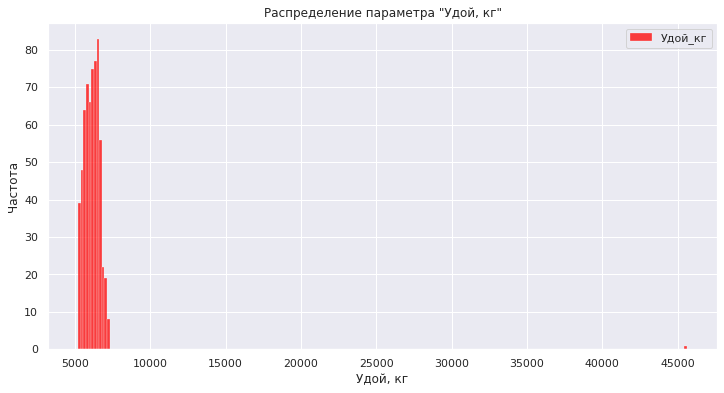

In [55]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=ferma_main, x="Удой_кг", color="red", label="Удой_кг")

plt.ylabel('Частота')
plt.xlabel('Удой, кг')
plt.title('Распределение параметра "Удой, кг"')
plt.legend() 
plt.show()

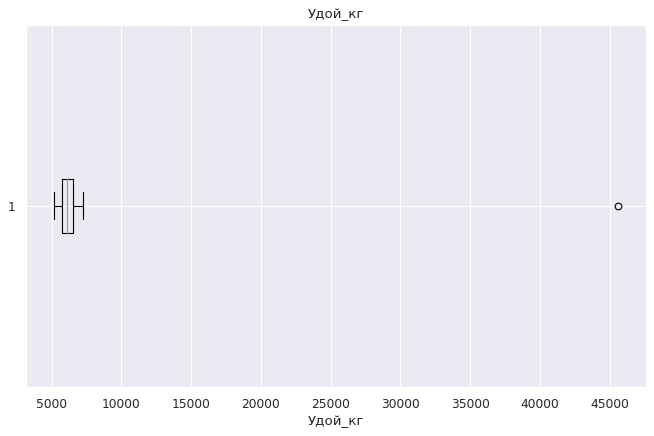

In [56]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(ferma_main['Удой_кг'], vert=False)
plt.title('Удой_кг')
plt.xlabel('Удой_кг')
plt.show()

Видно, что для признака Удой наблюдается аномальный выброс, соответствующий значению больше 45 тыс. кг в год. Строку, соответствующую этому выбросу необходимо удалить из датафрейма.

In [57]:
ferma_main.loc[ferma_main['Удой_кг'] > 10000]

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Жирность_%,Белок_%,Вкус_молока,Возраст
16,17,45616,11.5,1675.0,0.93,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,1,1


In [58]:
ferma_main = ferma_main.loc[ferma_main['Удой_кг'] < 10000].reset_index(drop= True)

In [59]:
ferma_main.loc[ferma_main['Удой_кг'] > 10000]

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Жирность_%,Белок_%,Вкус_молока,Возраст


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍  Согласен.

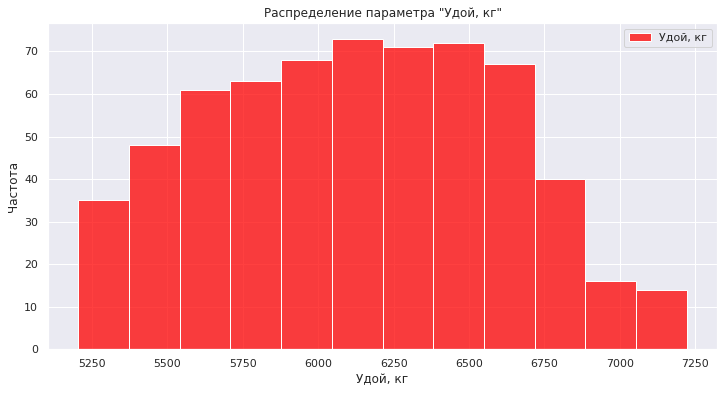

In [60]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=ferma_main, x="Удой_кг", color="red", label="Удой, кг")

plt.ylabel('Частота')
plt.xlabel('Удой, кг')
plt.title('Распределение параметра "Удой, кг"')
plt.legend() 
plt.show()

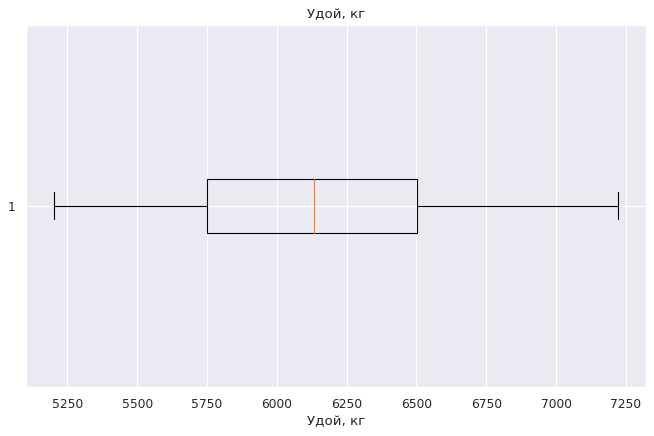

In [61]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(ferma_main['Удой_кг'], vert=False)
plt.title('Удой, кг')
plt.xlabel('Удой, кг')
plt.show()

In [62]:
print('Среднее значение параметра Удой:', round(ferma_main['Удой_кг'].mean(), 2), 'кг')

Среднее значение параметра Удой: 6125.97 кг


In [63]:
print('Медианное значение параметра Удой:', round(ferma_main['Удой_кг'].median(), 2), 'кг')

Медианное значение параметра Удой: 6132.5 кг


Теперь выбросов нет. Распределение параметра Удой является достаточно симметричным относительно центра. Среднее и медианное значения практически совпадают. Среднее значение равно 6126 кг молока в год.

Удалим строку, соответствующую id=17, так же из датафрейма ferma_dad. После чего проверим размер получившихся таблиц.

In [64]:
ferma_dad = ferma_dad.loc[ferma_dad['id'] != 17].reset_index(drop= True)

In [65]:
ferma_main.shape

(628, 12)

In [66]:
ferma_dad.shape

(628, 2)

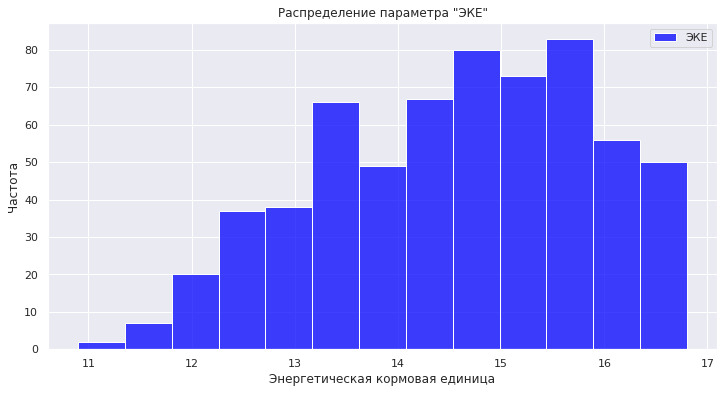

In [67]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=ferma_main, x="ЭКЕ", color="blue", label="ЭКЕ")

plt.ylabel('Частота')
plt.xlabel('Энергетическая кормовая единица')
plt.title('Распределение параметра "ЭКЕ"')
plt.legend() 
plt.show()

Выбросов и аномальных значений нет. Распределение смещено вправо.

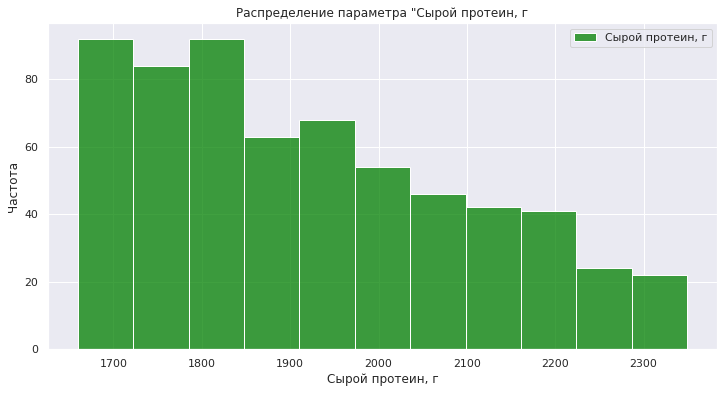

In [68]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=ferma_main, x="Сырой_протеин_г", color="green", label="Сырой протеин, г")

plt.ylabel('Частота')
plt.xlabel('Сырой протеин, г')
plt.title('Распределение параметра "Сырой протеин, г')
plt.legend() 
plt.show()

Выбросов и аномальных значений нет. Распределение смещено влево.

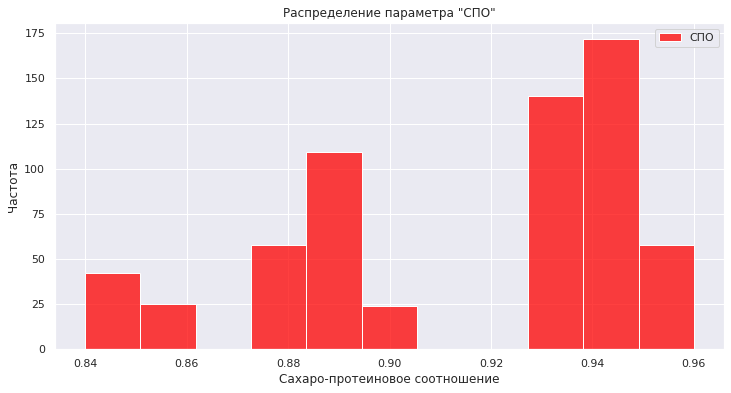

In [69]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=ferma_main, x="СПО", color="red", label="СПО")

plt.ylabel('Частота')
plt.xlabel('Сахаро-протеиновое соотношение')
plt.title('Распределение параметра "СПО"')
plt.legend() 
plt.show()

Значения параметра разбиты на три группы. Саммая многочисленная группа имеет значения, наиболее близкие к 1. Выбросов и аномальных значений нет.

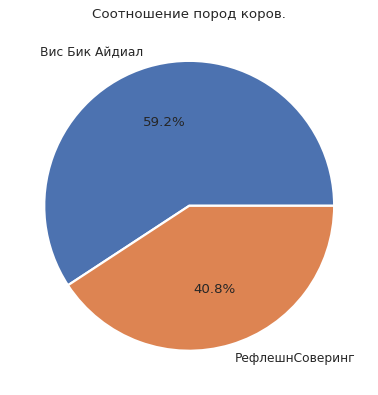

In [70]:
n1 = ferma_main[ferma_main['Порода'] == 'Вис Бик Айдиал']['id'].count()
n2 = ferma_main[ferma_main['Порода'] == 'РефлешнСоверинг']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['Вис Бик Айдиал', 'РефлешнСоверинг'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение пород коров.')
plt.show()

Примерно 60% коров в стаде имеют породу Вис Бик Айдиал и около 40% - РефлешнСоверинг.

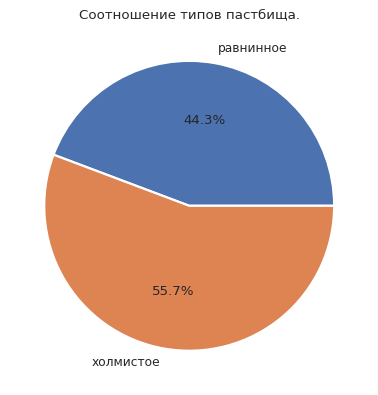

In [71]:
n1 = ferma_main[ferma_main['Тип_пастбища'] == 'равнинное']['id'].count()
n2 = ferma_main[ferma_main['Тип_пастбища'] == 'холмистое']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['равнинное', 'холмистое'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение типов пастбища.')
plt.show()

Чуть больше  коров пасется на холмистом пастбище - около 56%.

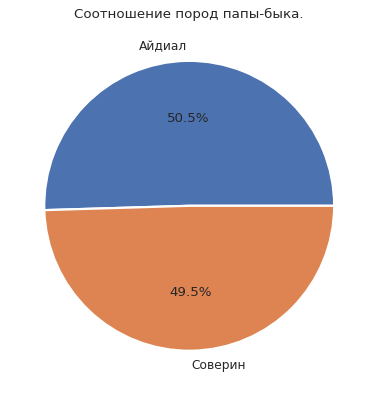

In [72]:
n1 = ferma_main[ferma_main['Порода_быка'] == 'Айдиал']['id'].count()
n2 = ferma_main[ferma_main['Порода_быка'] == 'Соверин']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['Айдиал', 'Соверин'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение пород папы-быка.')
plt.show()

Породы папы быка разделились практически поровну.

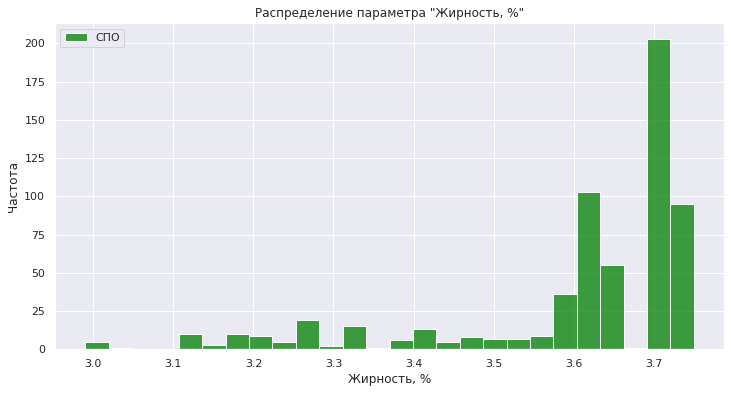

In [73]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=ferma_main, x="Жирность_%", color="green", label="СПО")

plt.ylabel('Частота')
plt.xlabel('Жирность, %')
plt.title('Распределение параметра "Жирность, %"')
plt.legend() 
plt.show()

Выбросов и аномальных значений нет. Жирность молока находится в пределах от 3 до 3.7%. Причем у большинства коров молоко жирное (3.7%). Распределение смещено вправо.

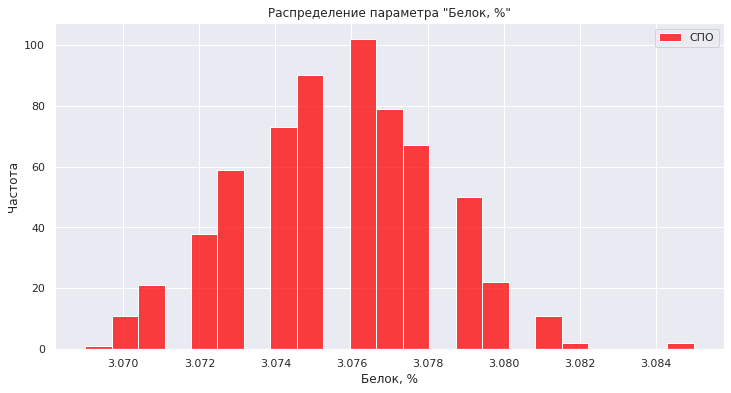

In [74]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=ferma_main, x="Белок_%", color="red", label="СПО")

plt.ylabel('Частота')
plt.xlabel('Белок, %')
plt.title('Распределение параметра "Белок, %"')
plt.legend() 
plt.show()

Выбросов и аномальных значений нет. Содержание белка практически одинаковое у всех коров, значение параметра немного колеблется вокруг 3.077%. Распределение параметра - дискретное, достаточно симметричное относительно центра.

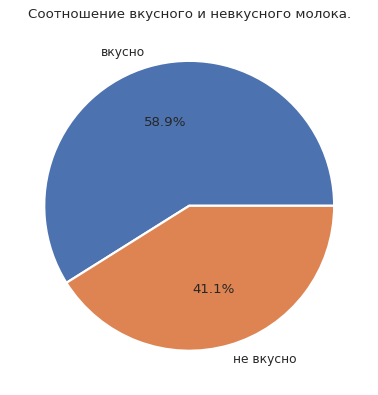

In [75]:
n1 = ferma_main[ferma_main['Вкус_молока'] == 1]['id'].count()
n2 = ferma_main[ferma_main['Вкус_молока'] == 0]['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['вкусно', 'не вкусно'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение вкусного и невкусного молока.')
plt.show()

Вкусного молока больше чем невкусного: примерно 60% против 40%.

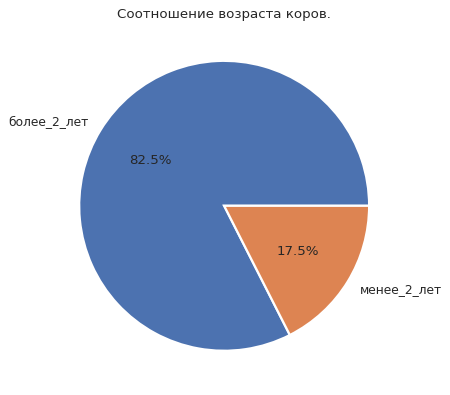

In [76]:
n1 = ferma_main[ferma_main['Возраст'] == 1]['id'].count()
n2 = ferma_main[ferma_main['Возраст'] == 0]['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['более_2_лет', 'менее_2_лет'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение возраста коров.')
plt.show()

Стадо, в основном, возрастное: большинство коров (82.5%) старше 2 лет.

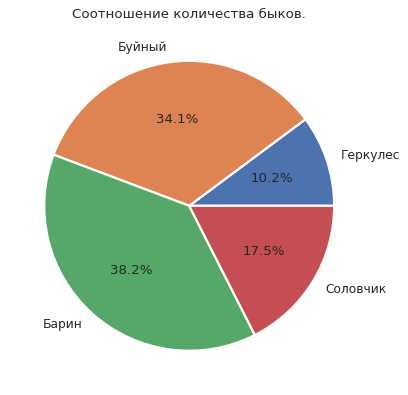

In [77]:
n1 = ferma_dad[ferma_dad['Имя_быка'] == 'Геркулес']['id'].count()
n2 = ferma_dad[ferma_dad['Имя_быка'] == 'Буйный']['id'].count()
n3 = ferma_dad[ferma_dad['Имя_быка'] == 'Барин']['id'].count()
n4 = ferma_dad[ferma_dad['Имя_быка'] == 'Соловчик']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3, n4], labels=['Геркулес', 'Буйный', 'Барин', 'Соловчик'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение количества быков.')
plt.show()

Быки Буйный и Барин встречаются чаще всего - примерно 34 и 38% соответственно.

Таким образом, анализ данных показал, что для признака Удой датафрейма ferma_main наблюдается аномальный выброс, соответствующий значению больше 45 тыс. кг в год. Строка, соответствующая этому выбросу, была удалена. Также была удалена строка в датафрейме ferma_dad, соответствующаяя этому выбросу (по номеру id). Для остальных признаков никаких аномалий и выбросов не было замечено.

## Корреляционный анализ

Построим корреляционную матрицу для количественных параметров датафрейма ferma_main.

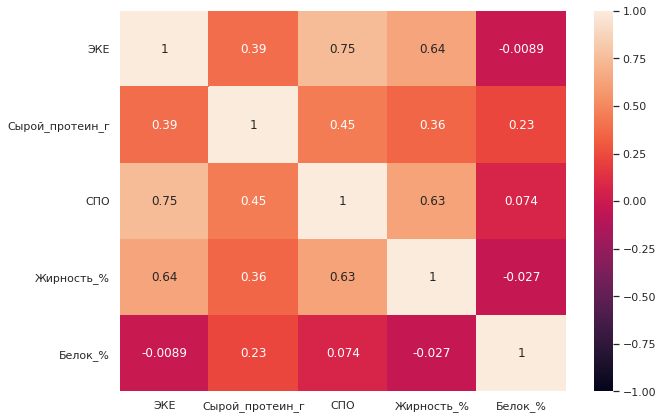

In [78]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.heatmap(ferma_main[num_col_main].corr(), vmin=-1, vmax=1, annot=True, ax=ax)

Самая сильная корреляция между признаками СПО и ЭКЕ, между жирностью и ЭКЕ и между СПО и жирностью. Более слабая корреляция между признаками Сырой протеин и ЭКЕ, Сырой протеин и СПО, Сырой протеин и жирность.

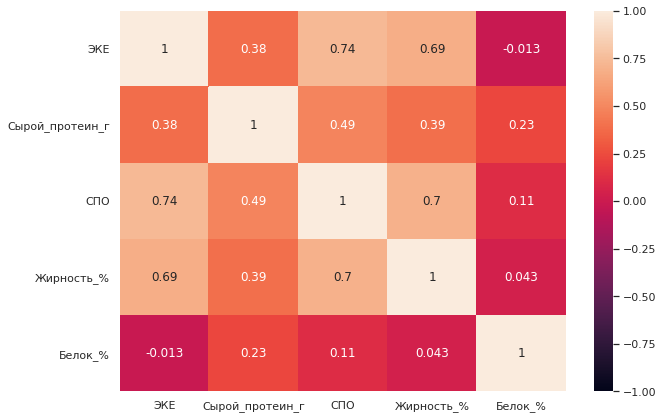

In [79]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.heatmap(ferma_main[num_col_main].corr(method='spearman'), vmin=-1, vmax=1, annot=True, ax=ax)

Посмотрим на корреляцию целевого параметра Удой с количественными признаками.

In [80]:
ferma_main.corr()[['Удой_кг']].sort_values(by='Удой_кг', ascending=False)

,Удой_кг
Удой_кг,1.000000
СПО,0.806339
ЭКЕ,0.765098
Возраст,0.660707
Жирность_%,0.600902
Сырой_протеин_г,0.446731
Вкус_молока,0.112839
Белок_%,0.002966
id,-0.006816


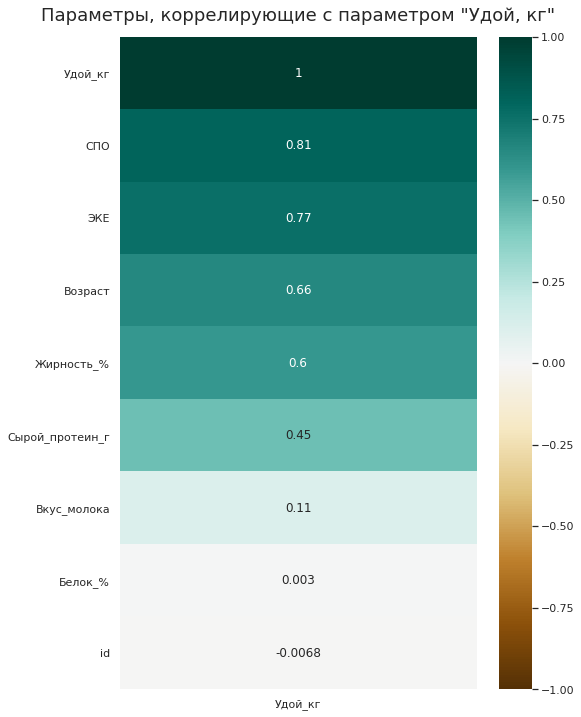

In [81]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(ferma_main.corr()[['Удой_кг']].sort_values(by='Удой_кг', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Параметры, коррелирующие с параметром "Удой, кг"', fontdict={'fontsize':18}, pad=16);

Наиболее сильно коррелируют с целевым признаком Удой такие параметры как: СПО, ЭКЕ и жирность.

Таким образом, для модели линейной регрессии можно взять следующие количественные признаки: ЭКЕ (и/или СПО), жирность и сырой протеин.

Для установления корреляций между целевым параметром Удой и категориальными признаками воспользуемся корреляцией Phi_K. Построим матрицу корреляций Phi_K.

In [82]:
ferma = ferma_main.drop('id', axis=1)

In [83]:
ferma_phik = ferma.phik_matrix(interval_cols=['Удой_кг', 'ЭКЕ', 'Сырой_протеин_г', 'СПО', 'Жирность_%', 'Белок_%'])
display(ferma_phik)

,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Жирность_%,Белок_%,Вкус_молока,Возраст
Удой_кг,1.000000,0.720719,0.463224,0.661359,0.164744,0.279540,0.519915,0.707654,0.058970,0.173122,0.998101
ЭКЕ,0.720719,1.000000,0.456484,0.591190,0.123086,0.106758,0.171355,0.715914,0.000000,0.272265,0.771596
Сырой_протеин_г,0.463224,0.456484,1.000000,0.387188,0.090925,0.096474,0.000000,0.397380,0.202474,0.176480,0.351685
СПО,0.661359,0.591190,0.387188,1.000000,0.062660,0.155349,0.425601,0.645581,0.073787,0.572702,0.744410
Порода,0.164744,0.123086,0.090925,0.062660,1.000000,0.213218,0.089330,0.222825,0.361851,0.000000,0.057295
Тип_пастбища,0.279540,0.106758,0.096474,0.155349,0.213218,1.000000,0.000000,0.000000,0.099908,0.269063,0.128455
Порода_быка,0.519915,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.134582,0.000000,0.355817
Жирность_%,0.707654,0.715914,0.397380,0.645581,0.222825,0.000000,0.000000,1.000000,0.000000,0.198793,0.677913
Белок_%,0.058970,0.000000,0.202474,0.073787,0.361851,0.099908,0.134582,0.000000,1.000000,0.143857,0.000000
Вкус_молока,0.173122,0.272265,0.176480,0.572702,0.000000,0.269063,0.000000,0.198793,0.143857,1.000000,0.165974


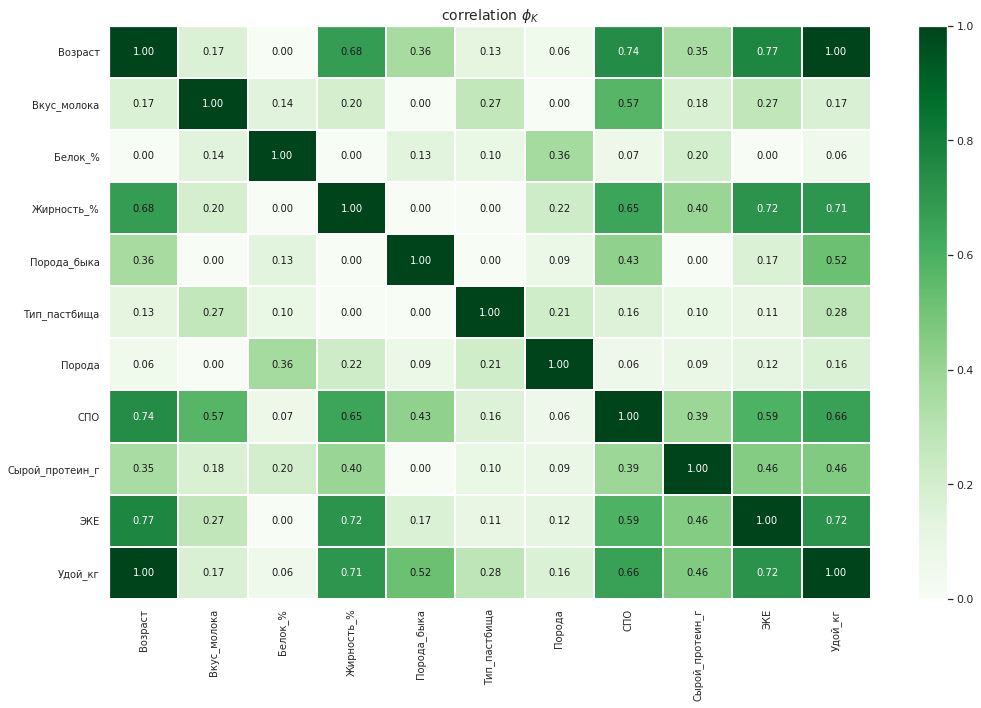

In [84]:
plot_correlation_matrix(ferma_phik.values, 
                        x_labels=ferma_phik.columns, 
                        y_labels=ferma_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

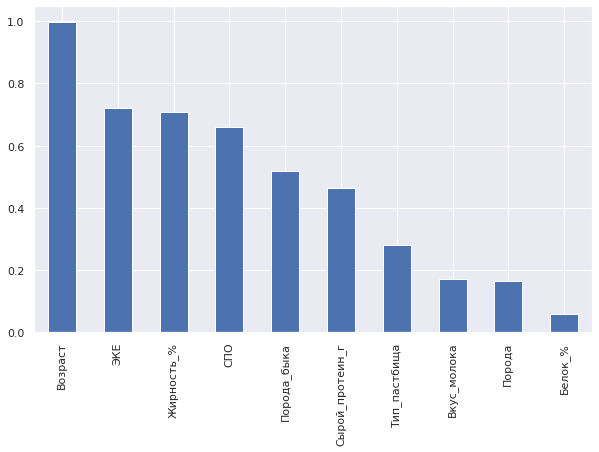

In [85]:
plt.figure(figsize=(10, 6))
_ = ferma_phik['Удой_кг'].sort_values(ascending=False)[1:].plot(kind='bar')

Коэффициенты корреляции между целевым признаком Удой и категориальными признаками (кроме Возраста) меньше 0,4. Возраст оказывается параметром, наиболее сильно коррелирующим с целевым признаком. По-видимому, из модели линейной регрессии спокойно можно выкинуть признак Белок_%. Порода вроде бы тоже не сильно коррелирует с величиной удоя, но из здравого смысла кажется, что этот параметр должен влиять на величину удоя. Поэтому при создании модели оставим этот параметр.

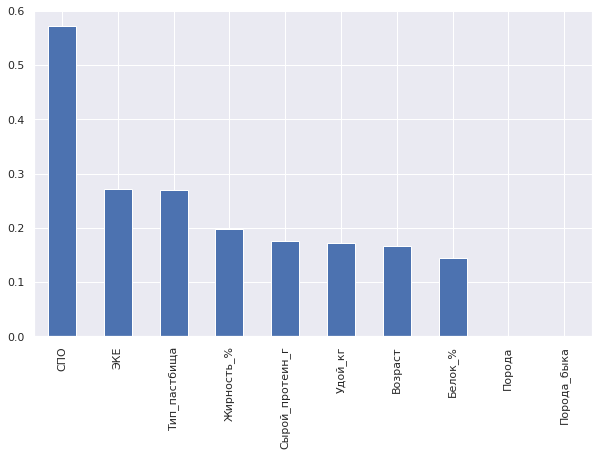

In [86]:
plt.figure(figsize=(10, 6))
_ = ferma_phik['Вкус_молока'].sort_values(ascending=False)[1:].plot(kind='bar')

Вторым целевым признаком, который мы будем использовать при создании модели логистической регрессии является параметр Вкус молока. Со вкусом молока сильнее всего коррелирует параметр СПО, а затем ЭКЕ. Остальные признаки (кроме параметра Порода быка) с меньшим коэффициентом корреляции оставим. Корреляции между Породой и вкусом молока, так же как и для Породы быка, не наблюдается, но так же как и в рассуждениях выше, кажется, что порода может оказывать влияние на вкус молока. Поэтому первоначально оставим этот параметр для создания модели логистической регрессии.

Построим попарные диаграммы рассеяния и диаграммы рассеяния для целевого признака Удой и всех количественных признаков с учётом значения категориальных признаков: порода (кодируется цветом) и возраста (кодируется размером точки).

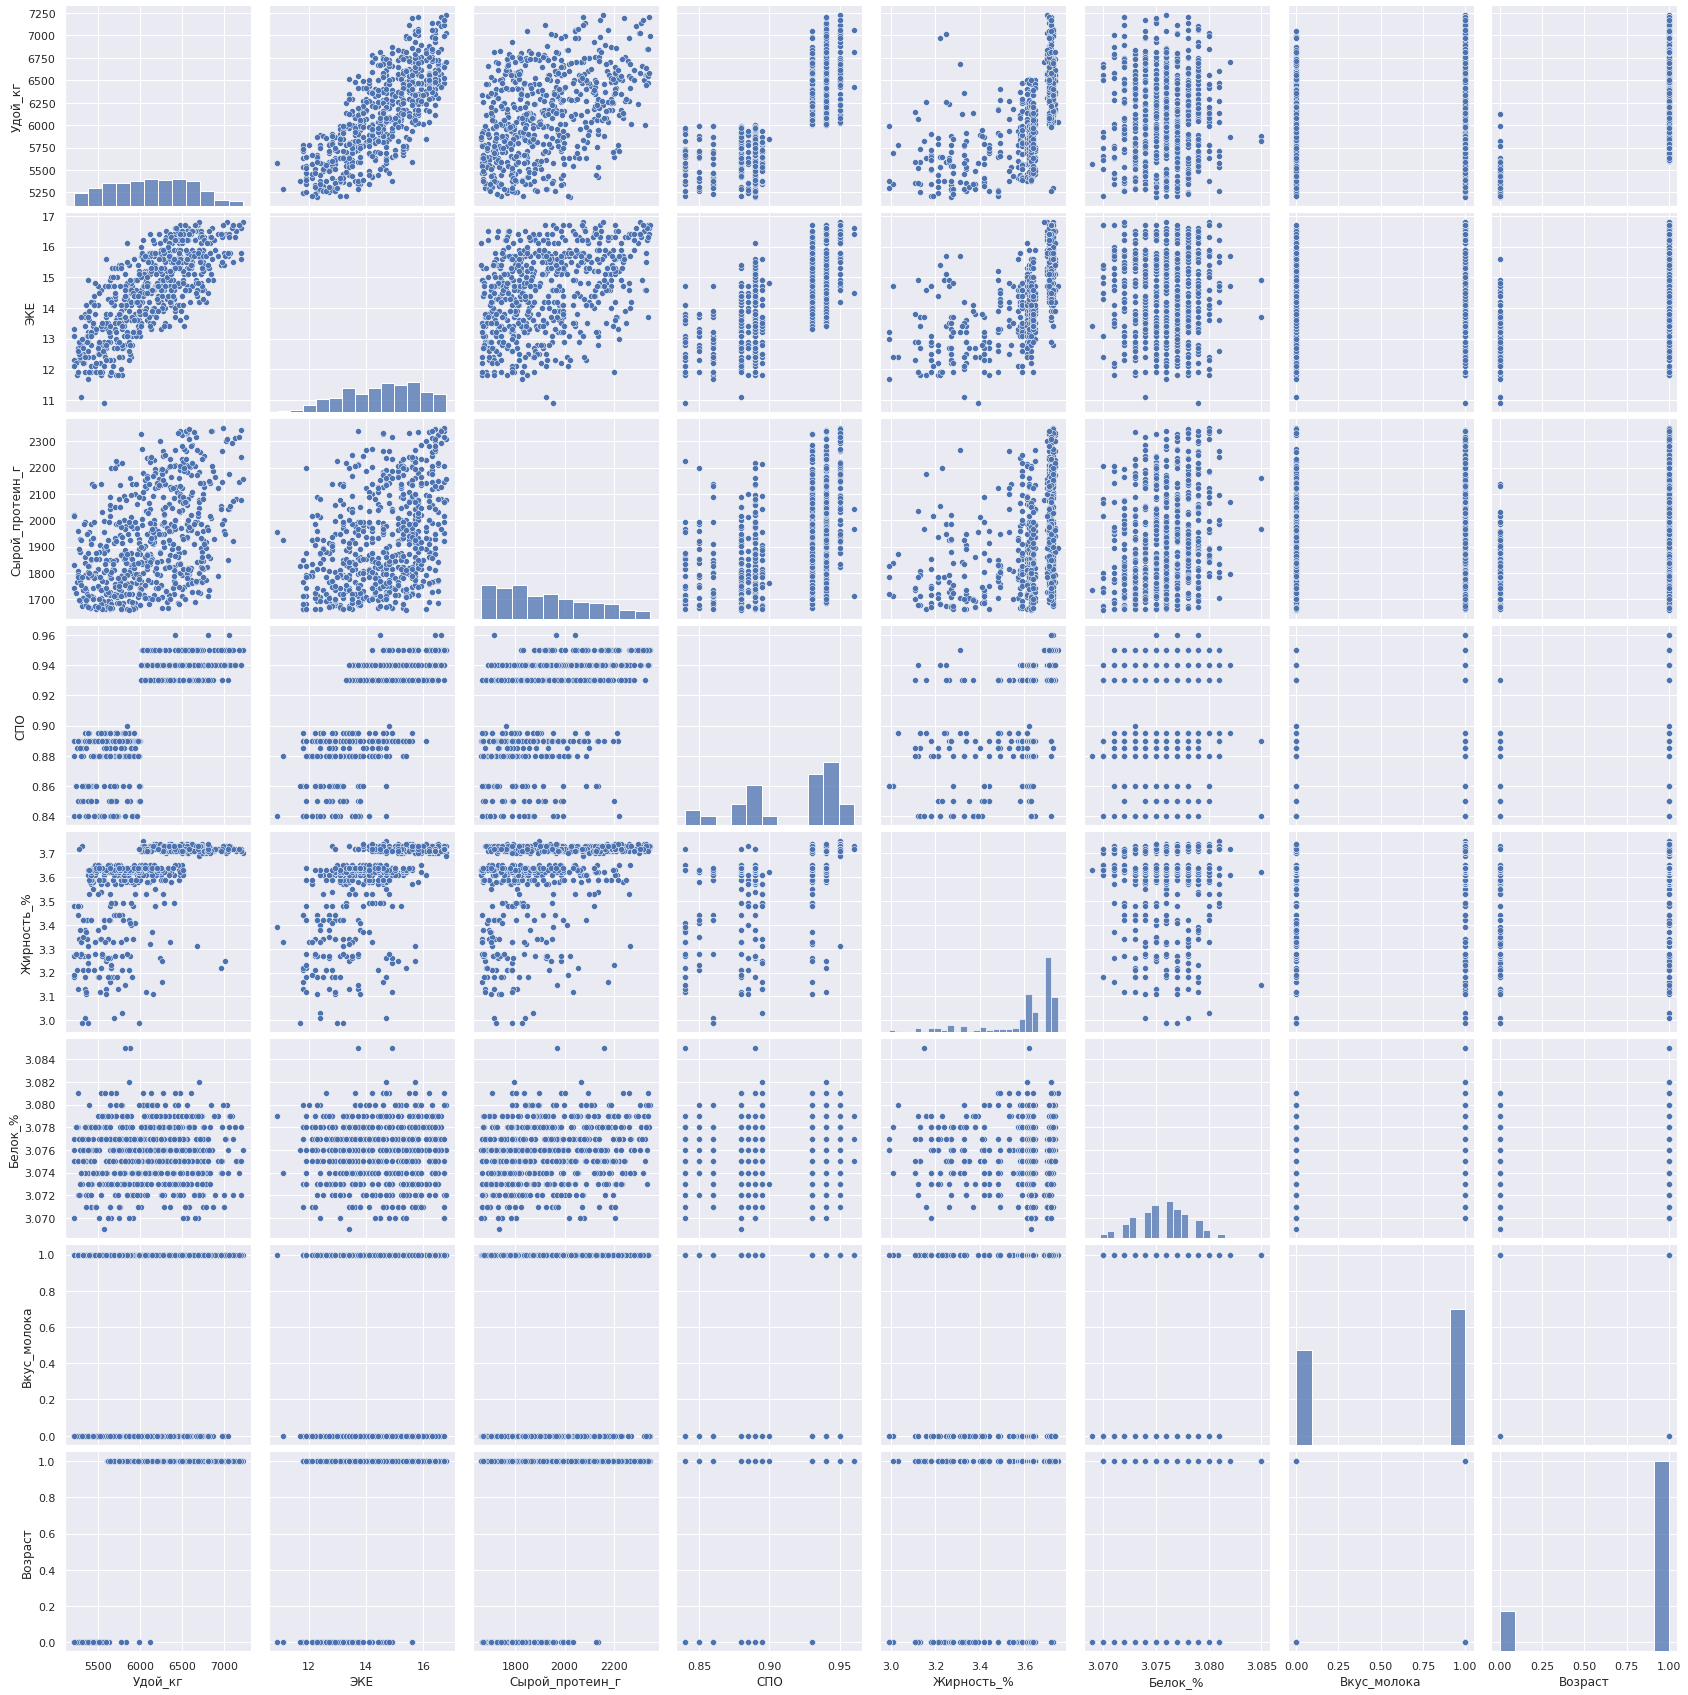

In [87]:
_ = sns.pairplot(ferma, height=3)

<AxesSubplot:xlabel='ЭКЕ', ylabel='Удой_кг'>

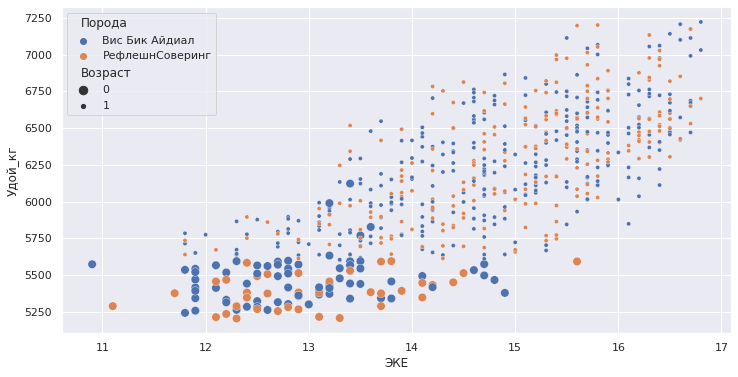

In [88]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=ferma_main, 
    x="ЭКЕ", 
    y="Удой_кг", 
    hue="Порода", 
    size="Возраст"
)

Между признаками Удой и ЭКЕ существует взаимосвязь. Она не линейная, скорее эту зависимость можно описать параболой. Зависимости удоя от породы не наблюдается. Зато есть явная зависимость от возраста. Хороший удой наблюдается только у коров старше двух лет.

<AxesSubplot:xlabel='Сырой_протеин_г', ylabel='Удой_кг'>

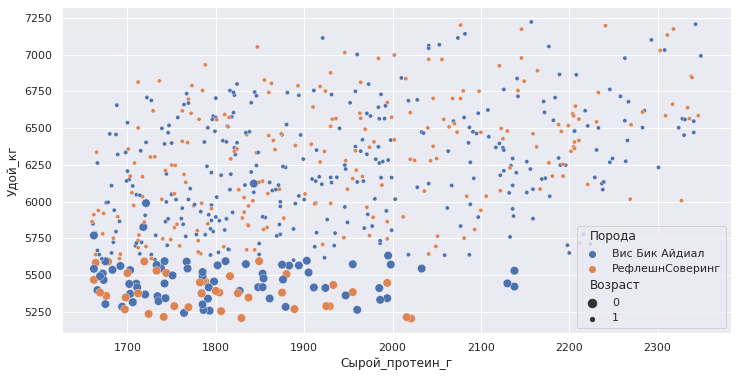

In [89]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=ferma_main, 
    x="Сырой_протеин_г", 
    y="Удой_кг", 
    hue="Порода", 
    size="Возраст"
)

Явной взаимосвязи между признаками Удой и Сырой протеин_г не наблюдается.

<AxesSubplot:xlabel='СПО', ylabel='Удой_кг'>

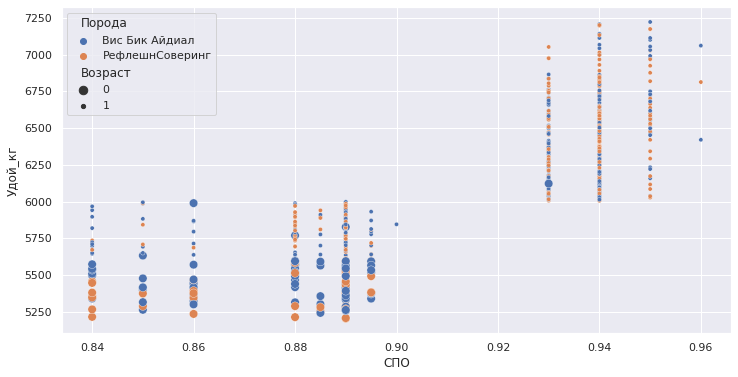

In [90]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=ferma_main, 
    x="СПО", 
    y="Удой_кг", 
    hue="Порода", 
    size="Возраст"
)

СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём  значение СПО - 0,92,  можно считать границей между кластерами. Зависимости от породы не наблюдается. Все значения, соответствующие СПО больше 0,92, относятся к коровам старше 2 лет.

<AxesSubplot:xlabel='Жирность_%', ylabel='Удой_кг'>

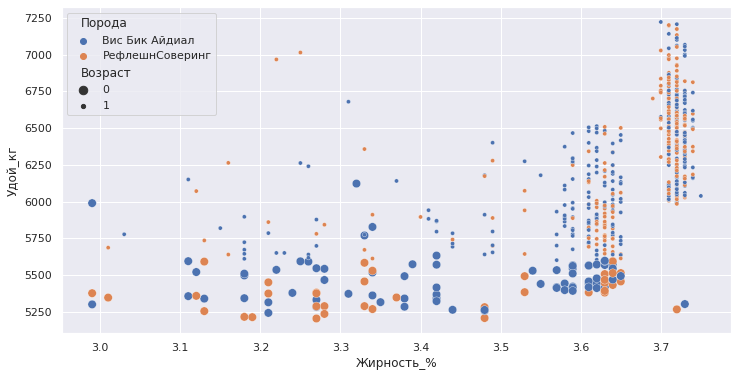

In [91]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=ferma_main, 
    x="Жирность_%", 
    y="Удой_кг", 
    hue="Порода", 
    size="Возраст"
)

Жирность_% и Удой связаны нелинейно. Пожалуй,  эту зависимость тоже можно описать параболой. Зависимости от породы не наблюдается. А вот коровы с самым жирным молоком и самым высоким удоем, в основном, старше 2 лет.

<AxesSubplot:xlabel='Белок_%', ylabel='Удой_кг'>

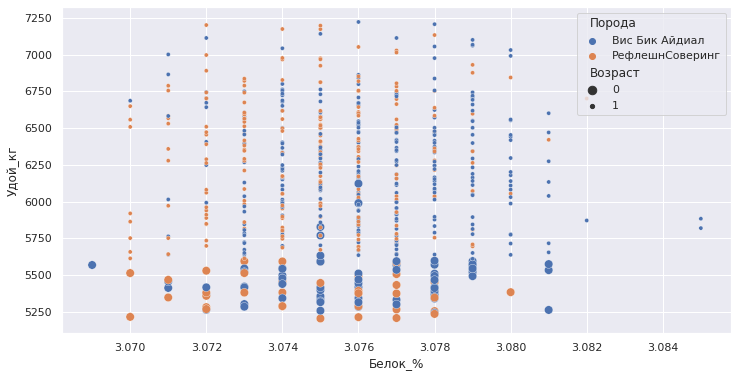

In [92]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=ferma_main, 
    x="Белок_%", 
    y="Удой_кг", 
    hue="Порода", 
    size="Возраст"
)

Зависимости Удоя от белка не наблюдается. На мой взгляд, колебания % белка по всей выборке совершенно незначительны, и значение белка в % можно было бы сделать константой. Это единственная диаграмма рассеяния, где немного видно влияние породы коров. Наиболее высокое значение белка в % наблюдается у коров породы Вис Бик Айдиал.

Статистический анализ данных показал следующее:
Самая сильная корреляция наблюдается между признаками СПО и ЭКЕ, между жирностью и ЭКЕ и между СПО и жирностью. Более слабая корреляция наблюдается между признаками Сырой протеин и ЭКЕ, Сырой протеин и СПО, Сырой протеин и жирность. 

Наиболее сильно коррелируют с целевым признаком Удой такие параметры как: СПО, ЭКЕ и жирность.

Таким образом, для модели линейной регрессии можно взять следующие количественные признаки: ЭКЕ, СПО и сырой протеин.

Для установления корреляций между целевым параметром Удой и категориальными признаками использовалась корреляция Phi_K и корреляция Спирмана. Построена матрицы корреляций Phi_K и Спирмана.

Коэффициенты корреляции между целевым признаком Удой и категориальными признаками (кроме Возраста) меньше 0,4.
Возраст оказывается параметром, наиболее сильно коррелирующим с целевым признаком.
По-видимому, из модели линейной регрессии спокойно можно выкинуть признак Белок_%. Порода вроде бы тоже не сильно коррелирует с величиной удоя, но из здравого смысла кажется, что этот параметр должен влиять на величину удоя. Поэтому при создании модели оставим этот параметр.

Вторым целевым признаком, который мы будем использовать при создании модели логистической регрессии является параметр Вкус молока.
Со вкусом молока сильнее всего коррелирует параметр СПО, а затем параметр ЭКЕ. Остальные признаки (кроме параметра Порода быка) с меньшим коэффициентом корреляции оставим. Корреляции между Породой и вкусом молока, так же как и для Породы быка, не наблюдается, но так же как и в рассуждениях выше, кажется, что порода может оказывать влияние на вкус молока.

Диаграммы рассеяния между целевым признаком Удой и количественными признаками показали следущее:

Между признаками Удой и ЭКЕ существует взаимосвязь. Она не линейная, скорее эту зависимость можно описать параболой. Зависимости удоя от породы не наблюдается. Зато есть явная зависимость от возраста. Хороший удой наблюдается только у коров старше двух лет.
Явной взаимосвязи между признаками Удой и Сырой протеин_г не наблюдается.
СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём значение СПО - 0,92, можно считать границей между кластерами. Зависимости от породы не наблюдается. Все значения, соответствующие СПО больше 0,92, относятся к коровам старше 2 лет.
Жирность_% и Удой связаны нелинейно. Пожалуй, эту зависимость тоже можно описать параболой. Зависимости от породы не наблюдается. А вот коровы с самым жирным молоком и самым высоким удоем, в основном, старше 2 лет.
Зависимости Удоя от белка не наблюдается. На мой взгляд, колебания % белка по всей выборке совершенно незначительны, и значение белка в % можно было бы сделать константой. Это единственная диаграмма рассеяния, где немного видно влияние породы коров. Наиболее высокое значение белка в % наблюдается у коров породы Вис Бик Айдиал.

## Обучение модели линейной регрессии

**Первая модель линейной регрессии**

In [93]:
cat_col_1 = ['Порода',
             'Тип_пастбища',
             'Порода_быка',
             'Возраст'
                ]
num_col_1 = ['СПО',
             'ЭКЕ',
             'Сырой_протеин_г'
                ]
# Отделение целевого признака
X1 = ferma_main.drop('Удой_кг', axis=1)

y1 = ferma_main['Удой_кг']
# Удаление излишних данных не влияющих на удой
X1 = X1.drop(['id', 'Белок_%', 'Вкус_молока', 'Жирность_%'], axis=1)
X1.head()

,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Возраст
0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Айдиал,1
1,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,Соверин,0
2,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,Соверин,1
3,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Айдиал,1
4,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,Соверин,0


In [94]:
# Разделение выборки на обучающую и целевую
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, 
    y1, 
    random_state=RANDOM_STATE)

In [95]:
# подготовка признаков (масштабирование и кодирование)
encoder1 = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

X1_train_ohe = encoder1.fit_transform(X1_train[cat_col_1])

X1_test_ohe = encoder1.transform(X1_test[cat_col_1])

encoder_col_1 = encoder1.get_feature_names_out()

In [96]:
scaler1 = StandardScaler()

X1_train_scaled = scaler1.fit_transform(X1_train[num_col_1])

X1_test_scaled = scaler1.transform(X1_test[num_col_1])

In [97]:
X1_train_ohe = pd.DataFrame(X1_train_ohe, columns=encoder_col_1)
X1_test_ohe = pd.DataFrame(X1_test_ohe, columns=encoder_col_1)

X1_train_scaled = pd.DataFrame(X1_train_scaled, columns=num_col_1)
X1_test_scaled = pd.DataFrame(X1_test_scaled, columns=num_col_1)

X1_train = pd.concat([X1_train_ohe, X1_train_scaled], axis=1)
X1_test = pd.concat([X1_test_ohe, X1_test_scaled], axis=1)

In [98]:
X1_train

,Порода_РефлешнСоверинг,Тип_пастбища_холмистое,Порода_быка_Соверин,Возраст_1,СПО,ЭКЕ,Сырой_протеин_г
0,1.0,1.0,1.0,1.0,0.837130,1.502378,1.079523
1,1.0,1.0,1.0,0.0,-0.703660,-1.557270,-0.196920
2,0.0,0.0,0.0,1.0,-1.011818,0.125537,-1.386085
3,0.0,1.0,0.0,1.0,0.837130,-0.103937,0.752230
4,0.0,0.0,0.0,1.0,-0.703660,-1.098323,0.828598
...,...,...,...,...,...,...,...
466,1.0,1.0,0.0,1.0,-0.549581,-0.639376,1.565008
467,0.0,0.0,0.0,1.0,0.528972,0.278519,-0.998788
468,1.0,0.0,0.0,1.0,-1.011818,-0.868849,-0.818777
469,0.0,0.0,0.0,1.0,-1.011818,-1.098323,0.130373


In [99]:
X1_test

,Порода_РефлешнСоверинг,Тип_пастбища_холмистое,Порода_быка_Соверин,Возраст_1,СПО,ЭКЕ,Сырой_протеин_г
0,0.0,1.0,0.0,1.0,-1.011818,-0.486393,-0.813322
1,1.0,1.0,1.0,1.0,0.837130,1.425887,0.026730
2,1.0,1.0,1.0,0.0,-1.628134,-0.486393,-0.682405
3,0.0,0.0,1.0,1.0,-1.011818,-0.945340,-1.058792
4,0.0,1.0,1.0,1.0,-0.703660,0.584484,-1.413360
...,...,...,...,...,...,...,...
152,0.0,1.0,0.0,1.0,0.528972,1.655361,0.506760
153,1.0,1.0,0.0,1.0,0.837130,0.660975,0.714046
154,0.0,0.0,0.0,1.0,0.837130,0.584484,0.114008
155,0.0,0.0,0.0,1.0,-0.549581,0.278519,-0.415116


In [100]:
model_lr1 = LinearRegression()

In [101]:
model_lr1.fit(X1_train, y1_train)

LinearRegression()

In [102]:
y1_pred = model_lr1.predict(X1_test)

In [103]:
r2 = r2_score(y1_test, y1_pred) 
r2

0.7844078173416967

In [104]:
residuals = y1_test - y1_pred

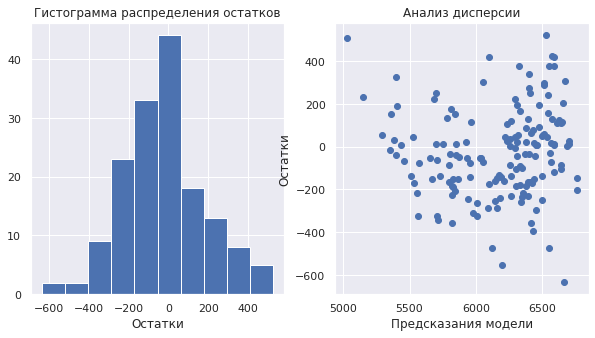

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[1].scatter(x = y1_pred, y = residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Посмотрим на случайность остатков первой модели: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.

Посмотрим на устойчивость остатков первой модели: остатки не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень низких и очень высоких значений удоя.
В следующей модели попробуем устранить нелинейность некоторых признаков.

Значение параметра R2 для первой модели равно 0.78

**Вторая модель линейной регрессии**

Во второй модели линейной регрессии исключим нелинейность признаков Удой и СПО, Удой и ЭКЕ.

In [106]:
cat_col_2 = ['Порода',
             'Тип_пастбища',
             'Порода_быка',
             'Возраст'
                ]
num_col_2 = ['СПО',
             'ЭКЕ',
             'Сырой_протеин_г'
                ]
# Отделение целевого признака
X2 = ferma_main.drop('Удой_кг', axis=1)
X2['СПО'] = X2['СПО'].apply(lambda x: 1 if x > 0.92 else 0)
X2['ЭКЕ'] = X2['ЭКЕ']**2

y2 = ferma_main['Удой_кг']

# Удаление излишних данных не влияющих на удой
X2 = X2.drop(['id', 'Белок_%', 'Вкус_молока', 'Жирность_%'], axis=1)
X2.head()

,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Возраст
0,201.64,1743.0,0,Вис Бик Айдиал,равнинное,Айдиал,1
1,163.84,2138.0,0,Вис Бик Айдиал,равнинное,Соверин,0
2,196.00,1854.0,0,РефлешнСоверинг,холмистое,Соверин,1
3,153.76,2012.0,0,РефлешнСоверинг,холмистое,Айдиал,1
4,163.84,1675.0,0,Вис Бик Айдиал,равнинное,Соверин,0


In [107]:
# Разделение выборки на обучающую и целевую
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, 
    y2, 
    random_state=RANDOM_STATE)

In [108]:
# подготовка признаков (масштабирование и кодирование)
encoder2 = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

X2_train_ohe = encoder2.fit_transform(X2_train[cat_col_2])

X2_test_ohe = encoder2.transform(X2_test[cat_col_2])

encoder_col_2 = encoder2.get_feature_names_out()

In [109]:
scaler2 = StandardScaler()

X2_train_scaled = scaler2.fit_transform(X2_train[num_col_2])

X2_test_scaled = scaler2.transform(X2_test[num_col_2])

In [110]:
X2_train_ohe = pd.DataFrame(X2_train_ohe, columns=encoder_col_2)
X2_test_ohe = pd.DataFrame(X2_test_ohe, columns=encoder_col_2)

X2_train_scaled = pd.DataFrame(X2_train_scaled, columns=num_col_2)
X2_test_scaled = pd.DataFrame(X2_test_scaled, columns=num_col_2)

X2_train = pd.concat([X2_train_ohe, X2_train_scaled], axis=1)
X2_test = pd.concat([X2_test_ohe, X2_test_scaled], axis=1)

In [111]:
X2_train

,Порода_РефлешнСоверинг,Тип_пастбища_холмистое,Порода_быка_Соверин,Возраст_1,СПО,ЭКЕ,Сырой_протеин_г
0,1.0,1.0,1.0,1.0,0.844232,1.577968,1.079523
1,1.0,1.0,1.0,0.0,-1.184509,-1.511438,-0.196920
2,0.0,0.0,0.0,1.0,-1.184509,0.082269,-1.386085
3,0.0,1.0,0.0,1.0,0.844232,-0.150235,0.752230
4,0.0,0.0,0.0,1.0,-1.184509,-1.102358,0.828598
...,...,...,...,...,...,...,...
466,1.0,1.0,0.0,1.0,-1.184509,-0.674102,1.565008
467,0.0,0.0,0.0,1.0,0.844232,0.239936,-0.998788
468,1.0,0.0,0.0,1.0,-1.184509,-0.890627,-0.818777
469,0.0,0.0,0.0,1.0,-1.184509,-1.102358,0.130373


In [112]:
X2_test

,Порода_РефлешнСоверинг,Тип_пастбища_холмистое,Порода_быка_Соверин,Возраст_1,СПО,ЭКЕ,Сырой_протеин_г
0,0.0,1.0,0.0,1.0,-1.184509,-0.527089,-0.813322
1,1.0,1.0,1.0,1.0,0.844232,1.490346,0.026730
2,1.0,1.0,1.0,0.0,-1.184509,-0.527089,-0.682405
3,0.0,0.0,1.0,1.0,-1.184509,-0.961737,-1.058792
4,0.0,1.0,1.0,1.0,-1.184509,0.561660,-1.413360
...,...,...,...,...,...,...,...
152,0.0,1.0,0.0,1.0,0.844232,1.754809,0.506760
153,1.0,1.0,0.0,1.0,0.844232,0.643423,0.714046
154,0.0,0.0,0.0,1.0,0.844232,0.561660,0.114008
155,0.0,0.0,0.0,1.0,-1.184509,0.239936,-0.415116


In [113]:
model_lr2 = LinearRegression()

In [114]:
model_lr2.fit(X2_train, y2_train)

LinearRegression()

In [115]:
y2_pred = model_lr2.predict(X2_test)

In [116]:
r2_2 = r2_score(y2_test, y2_pred) 
r2_2

0.8180879926867501

In [117]:
residuals2 = y2_test - y2_pred

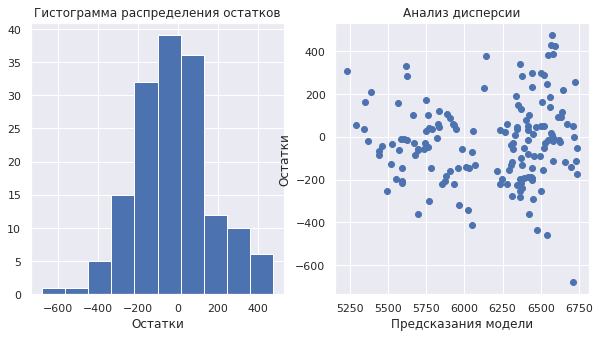

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals2)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[1].scatter(x = y2_pred, y = residuals2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Посмотрим на случайность остатков второй модели: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.

Посмотрим на устойчивость остатков второй модели: остатки, так же как и для первой модели, не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень высоких значений удоя. В следующей модели попробуем добавить в модель новый признак.

Значение параметра R2 для второй модели равно 0.82, оно выше, чем для первой модели.

**Третья модель линейной регрессии**

Добавим в данные новый признак - имя папы быка (Имя_быка)

In [119]:
ferma_main_dad = ferma_main.merge(ferma_dad, on='id', how='outer')
ferma_main_dad

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Жирность_%,Белок_%,Вкус_молока,Возраст,Имя_быка
0,1,5863,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,1,Буйный
1,2,5529,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,0,Соловчик
2,3,5810,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,1,Барин
3,4,5895,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,1,Буйный
4,5,5302,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,0,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,0,1,Буйный
624,626,5513,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,1,0,Барин
625,627,5970,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,0,1,Барин
626,628,5746,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,1,1,Барин


In [120]:
ferma_main_dad1 = ferma_main.merge(ferma_dad, on='id', how='inner')
ferma_main_dad1

,id,Удой_кг,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Жирность_%,Белок_%,Вкус_молока,Возраст,Имя_быка
0,1,5863,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,1,Буйный
1,2,5529,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,0,Соловчик
2,3,5810,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,1,Барин
3,4,5895,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,1,Буйный
4,5,5302,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,0,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,0,1,Буйный
624,626,5513,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,1,0,Барин
625,627,5970,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,0,1,Барин
626,628,5746,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,1,1,Барин


Посмотрим, как удой зависит от папы быка.

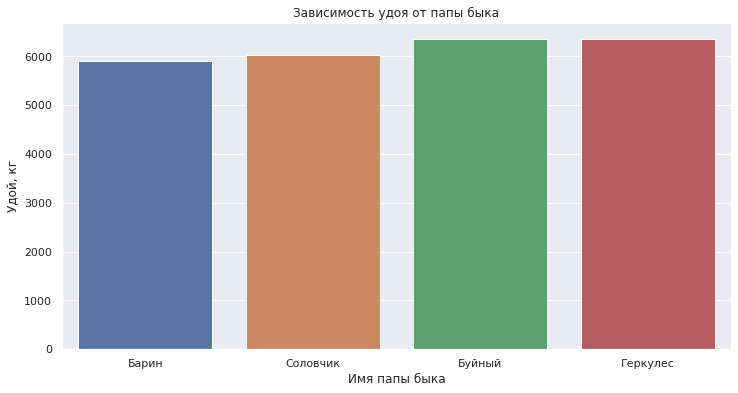

In [121]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.barplot(
    x="Имя_быка", 
    y="Удой_кг", 
    #hue="Имя_быка", 
    ci=None,
    data=ferma_main_dad.sort_values('Удой_кг', ascending=True)
)

plt.ylabel('Удой, кг')
plt.xlabel('Имя папы быка')
plt.title('Зависимость удоя от папы быка')
#plt.legend() 
plt.show()

По росту столбцов гистограммы видно, что наблюдается практически линейная зависимость целевого параметра Удой от параметра Имя_быка. 

In [122]:
cat_col_3 = ['Порода',
             'Тип_пастбища',
             'Порода_быка',
             'Возраст',
             'Имя_быка'
                ]
num_col_3 = ['СПО',
             'ЭКЕ',
             'Сырой_протеин_г'
                ]
# Отделение целевого признака
X3 = ferma_main_dad.drop('Удой_кг', axis=1)
X3['СПО'] = X3['СПО'].apply(lambda x: 1 if x > 0.92 else 0)
X3['ЭКЕ'] = X3['ЭКЕ']**2

y3 = ferma_main['Удой_кг']

# Удаление излишних данных не влияющих на удой
X3 = X3.drop(['id', 'Белок_%', 'Вкус_молока', 'Жирность_%'], axis=1)
X3.head()

,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Возраст,Имя_быка
0,201.64,1743.0,0,Вис Бик Айдиал,равнинное,Айдиал,1,Буйный
1,163.84,2138.0,0,Вис Бик Айдиал,равнинное,Соверин,0,Соловчик
2,196.00,1854.0,0,РефлешнСоверинг,холмистое,Соверин,1,Барин
3,153.76,2012.0,0,РефлешнСоверинг,холмистое,Айдиал,1,Буйный
4,163.84,1675.0,0,Вис Бик Айдиал,равнинное,Соверин,0,Барин


In [123]:
# Разделение выборки на обучающую и целевую
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, 
    y3, 
    random_state=RANDOM_STATE)

In [124]:
# подготовка признаков (масштабирование и кодирование)
encoder3 = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

X3_train_ohe = encoder3.fit_transform(X3_train[cat_col_3])

X3_test_ohe = encoder3.transform(X3_test[cat_col_3])

encoder_col_3 = encoder3.get_feature_names_out()

In [125]:
scaler3 = StandardScaler()

X3_train_scaled = scaler3.fit_transform(X3_train[num_col_3])

X3_test_scaled = scaler3.transform(X3_test[num_col_3])

In [126]:
X3_train_ohe = pd.DataFrame(X3_train_ohe, columns=encoder_col_3)
X3_test_ohe = pd.DataFrame(X3_test_ohe, columns=encoder_col_3)

X3_train_scaled = pd.DataFrame(X3_train_scaled, columns=num_col_3)
X3_test_scaled = pd.DataFrame(X3_test_scaled, columns=num_col_3)

X3_train = pd.concat([X3_train_ohe, X3_train_scaled], axis=1)
X3_test = pd.concat([X3_test_ohe, X3_test_scaled], axis=1)

In [127]:
X3_train

,Порода_РефлешнСоверинг,Тип_пастбища_холмистое,Порода_быка_Соверин,Возраст_1,Имя_быка_Буйный,Имя_быка_Геркулес,Имя_быка_Соловчик,СПО,ЭКЕ,Сырой_протеин_г
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.844232,1.577968,1.079523
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.184509,-1.511438,-0.196920
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.184509,0.082269,-1.386085
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.844232,-0.150235,0.752230
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.184509,-1.102358,0.828598
...,...,...,...,...,...,...,...,...,...,...
466,1.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.184509,-0.674102,1.565008
467,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.844232,0.239936,-0.998788
468,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.184509,-0.890627,-0.818777
469,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.184509,-1.102358,0.130373


In [128]:
X3_test

,Порода_РефлешнСоверинг,Тип_пастбища_холмистое,Порода_быка_Соверин,Возраст_1,Имя_быка_Буйный,Имя_быка_Геркулес,Имя_быка_Соловчик,СПО,ЭКЕ,Сырой_протеин_г
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.184509,-0.527089,-0.813322
1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.844232,1.490346,0.026730
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.184509,-0.527089,-0.682405
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.184509,-0.961737,-1.058792
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-1.184509,0.561660,-1.413360
...,...,...,...,...,...,...,...,...,...,...
152,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.844232,1.754809,0.506760
153,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.844232,0.643423,0.714046
154,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.844232,0.561660,0.114008
155,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.184509,0.239936,-0.415116


In [129]:
model_lr3 = LinearRegression()

In [130]:
model_lr3.fit(X3_train, y3_train)

LinearRegression()

In [131]:
y3_pred = model_lr3.predict(X3_test)

In [132]:
r2_3 = r2_score(y3_test, y3_pred) 
r2_3

0.8247542745210406

In [133]:
residuals3 = y3_test - y3_pred

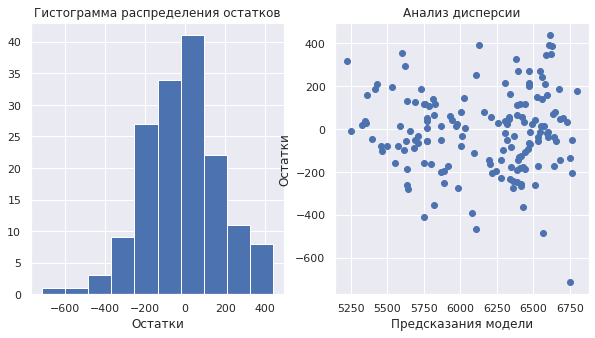

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals3)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[1].scatter(x = y3_pred, y = residuals3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Посмотрим на случайность остатков третьей модели: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.

Посмотрим на устойчивость остатков второй модели: остатки, так же как и для первой и второй моделей, не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень высоких значений удоя.

Значение параметра R2 для третьей модели равно 0.82, оно выше, чем для первой модели и такое же как для второй модели.

Оценим качество каждой модели по трём метрикам: MSE, MAE, RMSE.

In [135]:
mse1 = mean_squared_error(y1_test, y1_pred)
mse2 = mean_squared_error(y2_test, y2_pred)
mse3 = mean_squared_error(y3_test, y3_pred)
print('Среднеквадратичная ошибка первой модели:', round(mse1, 2))
print('Среднеквадратичная ошибка второй модели:', round(mse2, 2))
print('Среднеквадратичная ошибка третьей модели:', round(mse3, 2))

Среднеквадратичная ошибка первой модели: 43887.02
Среднеквадратичная ошибка второй модели: 37030.91
Среднеквадратичная ошибка третьей модели: 35673.89


In [136]:
rmse1 = mean_squared_error(y1_test, y1_pred, squared=False)
rmse2 = mean_squared_error(y2_test, y2_pred, squared=False)
rmse3 = mean_squared_error(y3_test, y3_pred, squared=False)
print('Корень из среднеквадратичной ошибки первой модели:', round(rmse1, 2))
print('Корень из среднеквадратичной ошибки второй модели:', round(rmse2, 2))
print('Корень из среднеквадратичной ошибки третьей модели::', round(rmse3, 2))

Корень из среднеквадратичной ошибки первой модели: 209.49
Корень из среднеквадратичной ошибки второй модели: 192.43
Корень из среднеквадратичной ошибки третьей модели:: 188.88


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [137]:
mae1 = mean_absolute_error(y1_test, y1_pred)
mae2 = mean_absolute_error(y2_test, y2_pred)
mae3 = mean_absolute_error(y3_test, y3_pred)
print('Средняя абсолютная ошибка первой модели:', round(mae1, 2))
print('Средняя абсолютная ошибка второй модели:', round(mae2, 2))
print('Средняя абсолютная ошибка третьей модели:', round(mae3, 2))

Средняя абсолютная ошибка первой модели: 164.24
Средняя абсолютная ошибка второй модели: 149.04
Средняя абсолютная ошибка третьей модели: 146.16


Из сравнения трех метрик: MSE, MAE, RMSE для трех моделей линейной регрессии видно, что наилучшие показатели у третьей модели.

Посмотрим на распределение абсолютной ошибки третьей модели.

In [138]:
ae3 = abs(y3_test-y3_pred)

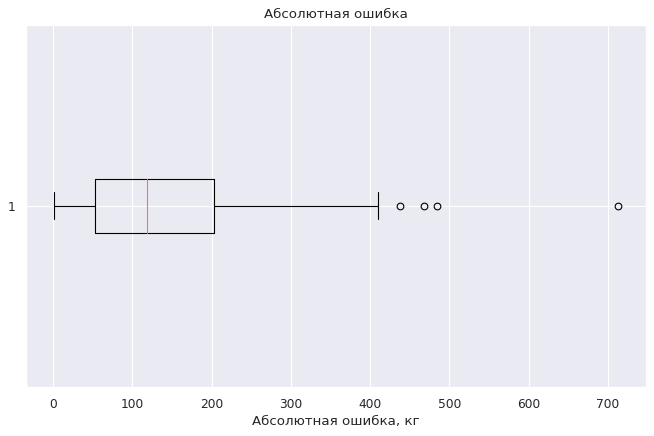

In [139]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(ae3, vert=False)
plt.title('Абсолютная ошибка')
plt.xlabel('Абсолютная ошибка, кг')
plt.show()

In [140]:
ae3.describe()

count    157.000000
mean     146.163024
std      120.008302
min        1.728216
25%       52.775430
50%      117.938708
75%      203.563870
max      712.793903
Name: Удой_кг, dtype: float64

Доверительный интервал прогноза третьей модели: (52.8, 203.6). Внутри этого диапазона лежит 50% ошибок. Квантили ошибки модели на тренировочных данных: 52.8, 203.6.

In [141]:
errors = y3_test-y3_pred

In [142]:
quantiles=(0.025, 0.975)

In [143]:
lower_quantile = np.quantile(errors, quantiles[0])
upper_quantile = np.quantile(errors, quantiles[1])

In [144]:
print(f"Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]")

Доверительный интервал прогноза: [-393.09963707901204, 355.9371511941207]


Из построенного ящика с усами видно, что хуже всего модель работает в области высоких значений целевого параметра.

**Предсказание модели**

Для прогнозирования удоя коров будем использовать третью модель, использующую больше всего признаков и имеющую лучшие метрики.

Добавим недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение). Возьмем из датасета ferma_main.csv средние значения каждого из признаков и увеличим их на 5%.

In [145]:
data_cow = cow_buy.drop(['Белок_%', 'Жирность_%'], axis=1)
data_cow['Сырой_протеин_г'] = ferma_main['Сырой_протеин_г'].mean()*1.05
data_cow['СПО'] = ferma_main['СПО'].mean()*1.05
data_cow['ЭКЕ'] = ferma_main['ЭКЕ'].mean()*1.05
data_cow['СПО'] = data_cow['СПО'].apply(lambda x: 1 if x > 0.92 else 0)
data_cow['ЭКЕ'] = data_cow['ЭКЕ']**2
data_cow  

,Порода,Тип_пастбища,Порода_быка,Имя_быка,Возраст,Сырой_протеин_г,СПО,ЭКЕ
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,1,2019.947532,1,233.361138
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0,2019.947532,1,233.361138
2,РефлешнСоверинг,равнинное,Соверин,Барин,1,2019.947532,1,233.361138
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,1,2019.947532,1,233.361138
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,1,2019.947532,1,233.361138
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,0,2019.947532,1,233.361138
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,1,2019.947532,1,233.361138
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,1,2019.947532,1,233.361138
8,РефлешнСоверинг,равнинное,Соверин,Барин,1,2019.947532,1,233.361138
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,0,2019.947532,1,233.361138


In [146]:
X_buy_ohe = encoder3.transform(data_cow[cat_col_3])
X_buy_scaled = scaler3.transform(data_cow[num_col_3])


X_buy_ohe = pd.DataFrame(X_buy_ohe, columns=encoder_col_3)

X_buy_scaled = pd.DataFrame(X_buy_scaled, columns=num_col_3)


X_buy = pd.concat([X_buy_ohe, X_buy_scaled], axis=1)

In [147]:
y_pred = model_lr3.predict(X_buy)

In [148]:
data_cow['Удой_кг_прогноз'] = y_pred

In [149]:
data_cow

,Порода,Тип_пастбища,Порода_быка,Имя_быка,Возраст,Сырой_протеин_г,СПО,ЭКЕ,Удой_кг_прогноз
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,1,2019.947532,1,233.361138,6609.919297
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0,2019.947532,1,233.361138,6378.711028
2,РефлешнСоверинг,равнинное,Соверин,Барин,1,2019.947532,1,233.361138,6283.999775
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,1,2019.947532,1,233.361138,6593.089377
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,1,2019.947532,1,233.361138,6542.146066
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,0,2019.947532,1,233.361138,6425.380218
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,1,2019.947532,1,233.361138,6609.919297
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,1,2019.947532,1,233.361138,6571.259737
8,РефлешнСоверинг,равнинное,Соверин,Барин,1,2019.947532,1,233.361138,6283.999775
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,0,2019.947532,1,233.361138,6400.540668


Для всех коров из датасета cow_buy модель спрогнозировала удай выше 6000 кг. Поэтому с точки зрения средего удоя за год, подходят все 20 коров из списка.

Для предсказания целевого признака Удой было обучено три модели линейной регрессии.
Во всех трех моделях не использовались признаки id, Белок_%, Жирность, Вкус_молока.

Анализ случайности остатков первой модели показал: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.
Анализ устойчивости остатков первой модели показал: остатки не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень низких и очень высоких значений удоя.  Значение параметра R2 для первой модели равно 0.78.

Во второй модели линейной регрессии исключили нелинейность признаков Удой и СПО, Удой и ЭКЕ.

Анализ случайности остатков второй модели показал: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.
Анализ устойчивости остатков второй модели показал: остатки, так же как и для первой модели, не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень высоких значений удоя.  Значение параметра R2 для второй модели равно 0.82, оно выше, чем для первой модели.

Для создания третьей модели добавили в данные новый признак - имя папы быка (Имя_быка).

Анализ случайности остатков третьей модели показал: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.
Анализ устойчивости остатков третьей модели показал: остатки, так же как и для первой и второй моделей, не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень высоких значений удоя. Значение параметра R2 для третьей модели равно 0.82, оно выше, чем для первой модели и такое же как для второй модели.

Была проведена оценка качества каждой модели по трём метрикам: MSE, MAE, RMSE.
Среднеквадратичная ошибка первой модели: 43887.02
Среднеквадратичная ошибка второй модели: 37030.91
Среднеквадратичная ошибка третьей модели: 35673.89
Корень из среднеквадратичной ошибки первой модели: 209.49
Корень из среднеквадратичной ошибки второй модели: 192.43
Корень из среднеквадратичной ошибки третьей модели:: 188.88
Средняя абсолютная ошибка первой модели: 164.24
Средняя абсолютная ошибка второй модели: 149.04
Средняя абсолютная ошибка третьей модели: 146.16

Из сравнения трех метрик: MSE, MAE, RMSE для трех моделей линейной регрессии видно, что наилучшие показатели у третьей модели.
Было построено распределение абсолютной ошибки третьей модели.

Доверительный интервал прогноза третьей модели: Доверительный интервал прогноза: (-393.1, 355.9).
Из построенного ящика с усами видно, что хуже всего модель работает в области высоких значений целевого параметра.

Для прогнозирования удоя коров будем была применена третья модель, использующая больше всего признаков и имеющая лучшие метрики.
Были добавлены недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение). Из датасета ferma_main.csv были взяты средние значения каждого из признаков и увеличены на 5%.
Для всех коров из датасета cow_buy модель спрогнозировала удай выше 6000 кг. Поэтому с точки зрения средего удоя за год, подходят все 20 коров из списка.

## Обучение модели логистической регрессии

In [150]:
cat_col_4 = ['Тип_пастбища',
             'Возраст',
             'Порода_быка',
             'Порода'
                ]
num_col_4 = ['СПО',
             'ЭКЕ',
             'Жирность_%',
             'Сырой_протеин_г',
             'Белок_%'
                ]
# Отделение целевого признака
X4 = ferma_main.drop('Вкус_молока', axis=1)
X4['СПО'] = X4['СПО'].apply(lambda x: 1 if x > 0.92 else 0)
X4['ЭКЕ'] = X4['ЭКЕ']**2

y4 = ferma_main['Вкус_молока']

# Удаление излишних данных не влияющих на вкус молока
X4 = X4.drop(['id', 'Удой_кг'], axis=1)
X4.head()

,ЭКЕ,Сырой_протеин_г,СПО,Порода,Тип_пастбища,Порода_быка,Жирность_%,Белок_%,Возраст
0,201.64,1743.0,0,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1
1,163.84,2138.0,0,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,0
2,196.00,1854.0,0,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,1
3,153.76,2012.0,0,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,1
4,163.84,1675.0,0,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,0


In [151]:
# Разделение выборки на обучающую и целевую
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, 
    y4, 
    random_state=RANDOM_STATE)

In [152]:
# подготовка признаков (масштабирование и кодирование)
encoder4 = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

X4_train_ohe = encoder4.fit_transform(X4_train[cat_col_4])

X4_test_ohe = encoder4.transform(X4_test[cat_col_4])

encoder_col_4 = encoder4.get_feature_names_out()

In [153]:
scaler4 = StandardScaler()

X4_train_scaled = scaler4.fit_transform(X4_train[num_col_4])

X4_test_scaled = scaler4.transform(X4_test[num_col_4])

In [154]:
X4_train_ohe = pd.DataFrame(X4_train_ohe, columns=encoder_col_4)
X4_test_ohe = pd.DataFrame(X4_test_ohe, columns=encoder_col_4)

X4_train_scaled = pd.DataFrame(X4_train_scaled, columns=num_col_4)
X4_test_scaled = pd.DataFrame(X4_test_scaled, columns=num_col_4)

X4_train = pd.concat([X4_train_ohe, X4_train_scaled], axis=1)
X4_test = pd.concat([X4_test_ohe, X4_test_scaled], axis=1)

In [155]:
X4_train

,Тип_пастбища_холмистое,Возраст_1,Порода_быка_Соверин,Порода_РефлешнСоверинг,СПО,ЭКЕ,Жирность_%,Сырой_протеин_г,Белок_%
0,1.0,1.0,1.0,1.0,0.844232,1.577968,0.562532,1.079523,-0.679069
1,1.0,0.0,1.0,1.0,-1.184509,-1.511438,-1.601817,-0.196920,-1.452568
2,0.0,1.0,0.0,0.0,-1.184509,0.082269,-2.563750,-1.386085,1.254677
3,1.0,1.0,0.0,0.0,0.844232,-0.150235,0.081565,0.752230,1.254677
4,0.0,1.0,0.0,0.0,-1.184509,-1.102358,0.201807,0.828598,0.094429
...,...,...,...,...,...,...,...,...,...
466,1.0,1.0,0.0,1.0,-1.184509,-0.674102,0.021444,1.565008,0.481179
467,0.0,1.0,0.0,0.0,0.844232,0.239936,0.682773,-0.998788,-1.065819
468,0.0,1.0,0.0,1.0,-1.184509,-0.890627,0.141686,-0.818777,-1.839317
469,0.0,1.0,0.0,0.0,-1.184509,-1.102358,0.021444,0.130373,-0.292320


In [156]:
X4_test

,Тип_пастбища_холмистое,Возраст_1,Порода_быка_Соверин,Порода_РефлешнСоверинг,СПО,ЭКЕ,Жирность_%,Сырой_протеин_г,Белок_%
0,1.0,1.0,0.0,0.0,-1.184509,-0.527089,0.201807,-0.813322,0.094429
1,1.0,1.0,1.0,1.0,0.844232,1.490346,0.622652,0.026730,-1.065819
2,1.0,0.0,1.0,1.0,-1.184509,-0.527089,0.141686,-0.682405,0.094429
3,0.0,1.0,1.0,0.0,-1.184509,-0.961737,0.081565,-1.058792,-0.679069
4,1.0,1.0,1.0,0.0,-1.184509,0.561660,0.081565,-1.413360,0.094429
...,...,...,...,...,...,...,...,...,...
152,1.0,1.0,0.0,0.0,0.844232,1.754809,0.682773,0.506760,-2.226067
153,1.0,1.0,0.0,1.0,0.844232,0.643423,-2.323267,0.714046,-0.679069
154,0.0,1.0,0.0,0.0,0.844232,0.561660,0.201807,0.114008,0.481179
155,0.0,1.0,0.0,0.0,-1.184509,0.239936,-0.760126,-0.415116,-1.065819


In [157]:
clf = LogisticRegression(random_state=RANDOM_STATE)

In [158]:
clf = clf.fit(X4_train, y4_train)

In [159]:
y4_pred = clf.predict(X4_test)

In [160]:
for feature_number, feature_name in enumerate(X4_train.columns):
    weight = clf.coef_[0, feature_number]
    print(f"{feature_name:<40}: {weight:+.10f}")

Тип_пастбища_холмистое                  : +0.5251405917
Возраст_1                               : +0.2168840205
Порода_быка_Соверин                     : -0.0941586722
Порода_РефлешнСоверинг                  : +0.0944743136
СПО                                     : -0.3830556272
ЭКЕ                                     : +0.6221492997
Жирность_%                              : -0.0210683603
Сырой_протеин_г                         : +0.1498432283
Белок_%                                 : +0.2705684749


In [161]:
acc = accuracy_score(y4_test, y4_pred)
print(acc)

0.6305732484076433


In [162]:
conf_matrix = confusion_matrix(y4_test, y4_pred)

In [163]:
conf_matrix

array([[24, 45],
       [13, 75]])

Text(0.5, 12.5, 'Predicted')

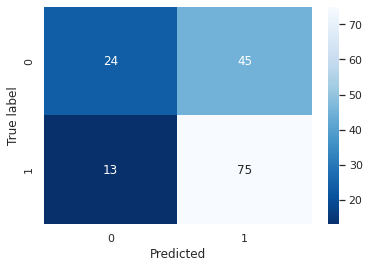

In [164]:
cm = confusion_matrix(y4_test, y4_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

In [165]:
cm[0,1]

45

Матрица ошибок, построенная на тестовых данных, показывает, что модель чаще совершает ошибки FP (ложноположительные), чем FN (ложноотрицательные).

In [166]:
recall = recall_score(y4_test, y4_pred, average="binary", pos_label=1)

In [167]:
precision = precision_score(y4_test, y4_pred, average="binary", pos_label=1)

In [168]:
print('recall: ',round(recall ,3))

recall:  0.852


In [169]:
print('precision: ',round(precision,3))

precision:  0.625


Метрика recall получилась выше, чем метрика precision. То есть, меньше внимания уделяется ошибкам первого рода (ошибки FP) и больше - ошибкам второго рода (FN).

Самое главное для заказчика — вкусное молоко. Соответственно, самой худшей ситуацией будет, когда на самом деле молоко невкусное, а предсказание дает ответ - вкусное (ложноположительный результат - FP). Прогнозы False Positive называют ошибками первого рода, и их надо свести к минимуму. То есть, при покупке коров критичнее ошибка первого рода. Более важной является метрика precision, ее надо максимизировать.

Выведем объекты по убыванию вероятности их принадлежности к классу 1.

In [170]:
y4_proba = clf.predict_proba(X4_test)[:,1]

data = pd.DataFrame(zip(y4_test, y4_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head()) 

     y_valid   y_proba
85         1  0.840618
66         1  0.837380
110        1  0.832339
51         1  0.829020
146        1  0.822741


Посмотрим на то, как модель будет работать при четырёх разных порогах.

In [171]:
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 4,endpoint=False)]
print(thresholds)

[0.1, 0.32, 0.55, 0.78]


Создадим расчётные столбцы с предсказаниями для каждого порога и добавим их в таблицу.

In [172]:
# создаём переменную, которая будет хранить список новых колонок

columns = []

# добавляем столбцы с новыми предсказаниями в таблицу

for i in thresholds:

    columns.append('y_pred_'+str(i).replace('.', '_'))

    data['y_pred_'+str(i).replace('.', '_')] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

# выведем 5 случайных строк

print(data.sample(5))

     y_valid   y_proba  y_pred_0_1  y_pred_0_32  y_pred_0_55  y_pred_0_78
86         1  0.735711           1            1            1            0
115        1  0.737380           1            1            1            0
146        1  0.822741           1            1            1            1
4          1  0.778129           1            1            1            0
66         1  0.837380           1            1            1            1


In [173]:
columns

['y_pred_0_1', 'y_pred_0_32', 'y_pred_0_55', 'y_pred_0_78']

In [174]:
print('Порог', '    precision', ' recall', ' FP', '  FN')
for i in columns:
    precision = precision_score(data['y_valid'],data[i], average="binary", pos_label=1)
    recall = recall_score(data['y_valid'],data[i], average="binary", pos_label=1)
    cm = confusion_matrix(data['y_valid'],data[i])
    print(i, '  ', round(precision ,2), ' ', round(recall ,2), '   ', cm[0,1], '  ', cm[1,0])

Порог     precision  recall  FP   FN
y_pred_0_1    0.56   1.0     69    0
y_pred_0_32    0.58   0.99     64    1
y_pred_0_55    0.65   0.82     39    16
y_pred_0_78    0.85   0.12     2    77


С увеличение порога значение precision растет, а recall падает. Видно, что наименьшее значение ложноположительных результатов (3) достигается при пороге 0.78. Посмотрим, при каком значениии будет достигнуто значение FP, равное 0. 

In [175]:
thresholds1 = [round(i,2) for i in np.linspace(0.80,1,num = 4,endpoint=False)]
print(thresholds1)

[0.8, 0.85, 0.9, 0.95]


In [176]:
columns1 = []
for i in thresholds1:

    columns1.append('y_pred_'+str(i).replace('.', '_'))

    data['y_pred_'+str(i).replace('.', '_')] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

In [177]:
print('Порог', '      precision', 'FP')
for i in columns1:
    precision = precision_score(data['y_valid'],data[i], average="binary", pos_label=1)
    cm = confusion_matrix(data['y_valid'],data[i])
    print(i, '  ', round(precision ,3), ' ', cm[0,1])

Порог       precision FP
y_pred_0_8    1.0   0
y_pred_0_85    0.0   0
y_pred_0_9    0.0   0
y_pred_0_95    0.0   0


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Самое оптимальное значение порога — 0.80. При таком пороге количество ложноположительных значений равно нулю. Правда модель начинает пропускать ложноотрицательные значения, когда на самом деле молоко вкусное, а модель предсказывает - невкусное. При подобной настройке порога мы минимизируем число критических ошибок, но при этом сильно снизим, и не всегда оправданно, количество коров, подходящих для покупки.

**Предсказание логистической модели**

In [178]:
data_cow1 = cow_buy
data_cow1['Сырой_протеин_г'] = ferma_main['Сырой_протеин_г'].mean()*1.05
data_cow1['СПО'] = ferma_main['СПО'].mean()*1.05
data_cow1['ЭКЕ'] = ferma_main['ЭКЕ'].mean()*1.05
data_cow1['СПО'] = data_cow1['СПО'].apply(lambda x: 1 if x > 0.92 else 0)
data_cow1['ЭКЕ'] = data_cow1['ЭКЕ']**2
data_cow1  

,Порода,Тип_пастбища,Порода_быка,Имя_быка,Жирность_%,Белок_%,Возраст,Сырой_протеин_г,СПО,ЭКЕ
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1,2019.947532,1,233.361138
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,0,2019.947532,1,233.361138
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1,2019.947532,1,233.361138
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,1,2019.947532,1,233.361138
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,1,2019.947532,1,233.361138
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,0,2019.947532,1,233.361138
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1,2019.947532,1,233.361138
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,1,2019.947532,1,233.361138
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1,2019.947532,1,233.361138
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,0,2019.947532,1,233.361138


In [179]:
X_buy1_ohe = encoder4.transform(data_cow1[cat_col_4])
X_buy1_scaled = scaler4.transform(data_cow1[num_col_4])


X_buy1_ohe = pd.DataFrame(X_buy1_ohe, columns=encoder_col_4)

X_buy1_scaled = pd.DataFrame(X_buy1_scaled, columns=num_col_4)


X_buy1 = pd.concat([X_buy1_ohe, X_buy1_scaled], axis=1)

In [180]:
y_pred_taste = clf.predict(X_buy1)

In [181]:
data_cow1['Вкус_молока'] = y_pred_taste

Выведем таблицу с предсказанием вкуса молока.

In [182]:
data_cow1

,Порода,Тип_пастбища,Порода_быка,Имя_быка,Жирность_%,Белок_%,Возраст,Сырой_протеин_г,СПО,ЭКЕ,Вкус_молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1,2019.947532,1,233.361138,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,0,2019.947532,1,233.361138,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1,2019.947532,1,233.361138,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,1,2019.947532,1,233.361138,0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,1,2019.947532,1,233.361138,1
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,0,2019.947532,1,233.361138,0
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1,2019.947532,1,233.361138,1
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,1,2019.947532,1,233.361138,1
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1,2019.947532,1,233.361138,1
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,0,2019.947532,1,233.361138,1


Выведем список коров, у уоторых средний удой за год выше 6000 кг и вкусное молоко.

In [183]:
data_cow1['Удой_кг_прогноз'] = data_cow['Удой_кг_прогноз']

In [184]:
data_cow1['Вкус_молока'] = data_cow1['Вкус_молока'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')

In [185]:
data_cow2 = data_cow1.query('Вкус_молока == "вкусно" and Удой_кг_прогноз > 6000').sort_values(['Удой_кг_прогноз'], ascending=False)

In [186]:
data_cow2

,Порода,Тип_пастбища,Порода_быка,Имя_быка,Жирность_%,Белок_%,Возраст,Сырой_протеин_г,СПО,ЭКЕ,Вкус_молока,Удой_кг_прогноз
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1,2019.947532,1,233.361138,вкусно,6609.919297
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1,2019.947532,1,233.361138,вкусно,6609.919297
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,1,2019.947532,1,233.361138,вкусно,6571.259737
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,1,2019.947532,1,233.361138,вкусно,6542.146066
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,1,2019.947532,1,233.361138,вкусно,6542.146066
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,0,2019.947532,1,233.361138,вкусно,6400.540668
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,0,2019.947532,1,233.361138,вкусно,6378.711028
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,1,2019.947532,1,233.361138,вкусно,6344.707860
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1,2019.947532,1,233.361138,вкусно,6283.999775
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1,2019.947532,1,233.361138,вкусно,6283.999775


In [187]:
print('Всего коров отобрано:', len(data_cow2))

Всего коров отобрано: 12


Таким образом, фермер может купить 12 коров.

In [188]:
y5_proba = clf.predict_proba(X_buy1)[:,1]

In [189]:
y5_proba = pd.DataFrame(y5_proba, columns = ['y_proba'])

In [190]:
data_cow1['Вкус_молока_0_78'] = y5_proba['y_proba'].apply(lambda x: 1 if x >= 0.78 else 0)

In [191]:
data_cow1['Вкус_молока_0_78'] = data_cow1['Вкус_молока_0_78'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')

In [192]:
data_cow1

,Порода,Тип_пастбища,Порода_быка,Имя_быка,Жирность_%,Белок_%,Возраст,Сырой_протеин_г,СПО,ЭКЕ,Вкус_молока,Удой_кг_прогноз,Вкус_молока_0_78
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1,2019.947532,1,233.361138,вкусно,6609.919297,не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,0,2019.947532,1,233.361138,вкусно,6378.711028,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1,2019.947532,1,233.361138,вкусно,6283.999775,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,1,2019.947532,1,233.361138,не вкусно,6593.089377,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,1,2019.947532,1,233.361138,вкусно,6542.146066,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,0,2019.947532,1,233.361138,не вкусно,6425.380218,не вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1,2019.947532,1,233.361138,вкусно,6609.919297,не вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,1,2019.947532,1,233.361138,вкусно,6571.259737,не вкусно
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1,2019.947532,1,233.361138,вкусно,6283.999775,не вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,0,2019.947532,1,233.361138,вкусно,6400.540668,не вкусно


Для предсказания целевого признака Вкус молока была обучена модель логистической регрессии.

Для создания модели были использованы те признаки, для которых было продемонстрировано наличие корреляции с целевым признаком Вкус молока. Оставлены все те признаки, которые относятся к химическому составу молока и, соответственно, могут влиять на его вкус.

Матрица ошибок, построенная на тестовых данных, показывает, что модель чаще совершает ошибки FP (ложноположительные), чем FN (ложноотрицательные).

Значение метрики accuracy равно 0.631,  recall –  0.852, precision – 0.625.

Метрика recall получилась выше, чем метрика precision. То есть, меньше внимания уделяется ошибкам первого рода (ошибки FP) и больше - ошибкам второго рода (FN).


Самое главное для заказчика — вкусное молоко. Соответственно, самой худшей ситуацией будет, когда на самом деле молоко невкусное, а предсказание дает ответ - вкусное (ложноположительный результат - FP). Прогнозы False Positive называют ошибками первого рода, и их надо свести к минимуму. То есть, при покупке коров критичнее ошибка первого рода. Более важной является метрика precision, ее надо максимизировать.

Проведен анализ того, как модель будет работать при четырёх разных порогах.
С увеличением порога значение precision растет, а recall падает. Наименьшее значение ложноположительных результатов (2) достигается при пороге 0.78. 
Самое оптимальное значение порога — 0.80. При таком пороге количество ложноположительных значений равно нулю. Правда модель начинает пропускать ложноотрицательные значения, когда на самом деле молоко вкусное, а модель предсказывает - невкусное. При подобной настройке порога мы минимизируем число критических ошибок, но при этом сильно снизим, и не всегда оправданно, количество коров, подходящих для покупки.

При помощи созданной логистической модели было проведено предсказание вкуса молока.
При отборе коров, удовлетворяющих двум условиям, поставленным фермером (средний удой за год выше 6000 кг и вкусное молоко), был получен список 12 коров из датафрейма cow_buy.
Таким образом, фермер может купить 12 коров. 


## Итоговые выводы

Для анализа предоставлено три датасета ferma_main с данными о стаде фермера на текущий момент, ferma_dad с данными об имени папы каждой коровы и cow_buy с данными о коровах «ЭкоФермы», которые фермер хочет изучить перед покупкой.

Визуализация данных в трех датасетах показывает, что имеются проблемы с названиями столбцов, которые в дальнейшем названы однотипно во всех трех таблицах.
В процессе предобработки данных был изменен тип данных в столбцах с количественными признаками в датафреймах ferma_main и cow_buy (с object на float). В датафрейме ferma_main были обнаружены и удалены явные дубликаты (5 шт.). Пропусков в данных не обнаружено. Были изменены названия некоторых столбцов, чтобы в них не было пробелов. Также были исправлено значение типа пастбища в датафрейме ferma_main: были убраны заглавные буквы и значение 'равнинные' заменено на 'равнинное'. Тип данных в столбцах Вкус молока и Возраст заменен на бинарный (0/1).

Анализ данных показал, что для признака Удой датафрейма ferma_main наблюдается аномальный выброс, соответствующий значению больше 45 тыс. кг в год. Строка, соответствующая этому выбросу была удалена. Также была удалена строка в датафрейме ferma_dad, соответствующаяя этому выбросу (по номеру id). Распределение параметра Удой является достаточно симметричным относительно центра. Среднее и медианное значения практически совпадают. Среднее значение равно 6126 кг молока в год. Для остальных количественных  признаков никаких аномалий и выбросов не было замечено.

Примерно 60% коров в стаде имеют породу Вис Бик Айдиал и около 40% - РефлешнСоверинг.
Чуть больше коров пасется на холмистом, а не на равнинном пастбище - около 56%.
Породы папы быка (Айдиал и Соверин) разделились практически поровну.
Вкусного молока больше чем невкусного: примерно 60% против 40%.
Стадо, в основном, возрастное: большинство коров (82.5%) старше 2 лет.
Быки-папы Буйный и Барин встречаются чаще всего - примерно 34 и 38% соответственно.

Статистический анализ данных показал следующее:
Самая сильная корреляция наблюдается между признаками СПО и ЭКЕ, между жирностью и ЭКЕ и между СПО и жирностью. Более слабая корреляция наблюдается между признаками Сырой протеин и ЭКЕ, Сырой протеин и СПО, Сырой протеин и жирность. Между признаками СПО и ЭКЕ коэффициент корреляции Пирсона превышает значение 0,7.

Наиболее сильно коррелируют с целевым признаком Удой такие параметры как: СПО, ЭКЕ и жирность.

Таким образом, для модели линейной регрессии можно взять следующие количественные признаки: ЭКЕ, СПО и сырой протеин.

Для установления корреляций между целевым параметром Удой и категориальными признаками использовалась корреляция Phi_K и корреляция Спирмана. Построена матрица корреляций Phi_K.

Коэффициенты корреляции между целевым признаком Удой и категориальными признаками (кроме Возраста) меньше 0,4.
Возраст оказывается параметром, наиболее сильно коррелирующим с целевым признаком.
По-видимому, из модели линейной регрессии спокойно можно выкинуть признак Белок_%. Порода вроде бы тоже не сильно коррелирует с величиной удоя, но из здравого смысла кажется, что этот параметр должен влиять на величину удоя. Поэтому при создании модели оставим этот параметр.

Вторым целевым признаком, который мы будем использовать при создании модели логистической регрессии является параметр Вкус молока.
Со вкусом молока сильнее всего коррелирует параметр СПО, а затем параметр ЭКЕ. Остальные признаки (кроме параметра Порода быка) с меньшим коэффициентом корреляции оставим. Корреляции между Породой и вкусом молока, так же как и для Породы быка, не наблюдается, но так же как и в рассуждениях выше, кажется, что порода может оказывать влияние на вкус молока.

Диаграммы рассеяния между целевым признаком Удой и количественными признаками показали следущее:

Между признаками Удой и ЭКЕ существует взаимосвязь. Она не линейная, скорее эту зависимость можно описать параболой. Зависимости удоя от породы не наблюдается. Зато есть явная зависимость от возраста. Хороший удой наблюдается только у коров старше двух лет.
Явной взаимосвязи между признаками Удой и Сырой протеин_г не наблюдается.

СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём значение СПО - 0,92, можно считать границей между кластерами. Зависимости от породы не наблюдается. Все значения, соответствующие СПО больше 0,92, относятся к коровам старше 2 лет.

Жирность_% и Удой связаны нелинейно. Пожалуй, эту зависимость тоже можно описать параболой. Зависимости от породы не наблюдается. А вот коровы с самым жирным молоком и самым высоким удоем, в основном, старше 2 лет.

Зависимости Удоя от белка не наблюдается. На мой взгляд, колебания % белка по всей выборке совершенно незначительны, и значение белка в % можно было бы сделать константой. Это единственная диаграмма рассеяния, где немного видно влияние породы коров.
Наиболее высокое значение белка в % наблюдается у коров породы Вис Бик Айдиал.

Для предсказания целевого признака Удой было обучено три модели линейной регрессии.

Во всех трех моделях не использовались признаки id, Белок_%, Жирность_%, Вкус_молока.

Анализ случайности остатков первой модели показал: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.
Анализ устойчивости остатков первой модели показал: остатки не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень низких и очень высоких значений удоя.  Значение параметра R2 для первой модели равно 0.78.


Во второй модели линейной регрессии исключили нелинейность признаков Удой и СПО, Удой и ЭКЕ.

Анализ случайности остатков второй модели показал: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.
Анализ устойчивости остатков второй модели показал: остатки, так же как и для первой модели, не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень высоких значений удоя.  Значение параметра R2 для второй модели равно 0.82, оно выше, чем для первой модели.

Для создания третьей модели добавили в данные новый признак - имя папы быка (Имя_быка).

Анализ случайности остатков третьей модели показал: остатки практически нормально распределены, а их график — достаточно симметричен относительно самого частого значения.
Анализ устойчивости остатков третьей модели показал: остатки, так же как и для первой и второй моделей, не имеют постоянной дисперсии на всём интервале использования модели. На некоторых участках разброс значений остатков сильно больше, чем на других. Особенно это характерно для очень высоких значений удоя. Значение параметра R2 для третьей модели равно 0.82, оно выше, чем для первой модели и такое же как для второй модели.

Была проведена оценка качества каждой модели по трём метрикам: MSE, MAE, RMSE. Среднеквадратичная ошибка первой модели: 43887.02 Среднеквадратичная ошибка второй модели: 37030.91 Среднеквадратичная ошибка третьей модели: 35673.89 Корень из среднеквадратичной ошибки первой модели: 209.49 Корень из среднеквадратичной ошибки второй модели: 192.43 Корень из среднеквадратичной ошибки третьей модели:: 188.88 Средняя абсолютная ошибка первой модели: 164.24 Средняя абсолютная ошибка второй модели: 149.04 Средняя абсолютная ошибка третьей модели: 146.16
Из сравнения трех метрик: MSE, MAE, RMSE для трех моделей линейной регрессии видно, что наилучшие показатели у третьей модели.

Было построено распределение абсолютной ошибки третьей модели.
Доверительный интервал прогноза третьей модели: (-393.1, 355.9). 
Из построенного ящика с усами видно, что хуже всего модель работает в области высоких значений целевого параметра.

Для прогнозирования удоя коров была применена третья модель, использующая больше всего признаков и имеющая лучшие метрики.
Были добавлены недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение). Из датасета ferma_main.csv были взяты средние значения каждого из признаков и увеличены на 5%.
Для всех коров из датасета cow_buy модель спрогнозировала удой выше 6000 кг. Поэтому с точки зрения средего удоя за год, подходят все 20 коров из списка.

Для предсказания целевого признака Вкус молока была обучена модель логистической регрессии.

Для создания модели были использованы все признаки, кроме целевых и id.

Матрица ошибок, построенная на тестовых данных, показывает, что модель чаще совершает ошибки FP (ложноположительные), чем FN (ложноотрицательные).

Значение метрики accuracy равно 0.631,  recall –  0.852, precision – 0.625.
Метрика recall получилась выше, чем метрика precision. То есть, меньше внимания уделяется ошибкам первого рода (ошибки FP) и больше - ошибкам второго рода (FN).


Самое главное для заказчика — вкусное молоко. Соответственно, самой худшей ситуацией будет, когда на самом деле молоко невкусное, а предсказание дает ответ - вкусное (ложноположительный результат - FP). Прогнозы False Positive называют ошибками первого рода, и их надо свести к минимуму. То есть, при покупке коров критичнее ошибка первого рода. Более важной является метрика precision, ее надо максимизировать.

Проведен анализ того, как модель будет работать при четырёх разных порогах.
С увеличением порога значение precision растет, а recall падает. 
Самое оптимальное значение порога — 0.80. При таком пороге количество ложноположительных значений равно нулю. Правда модель начинает пропускать ложноотрицательные значения, когда на самом деле молоко вкусное, а модель предсказывает - невкусное. При подобной настройке порога мы минимизируем число критических ошибок, но при этом сильно снизим, и не всегда оправданно, количество коров, подходящих для покупки.

При помощи созданной логистической модели было проведено предсказание вкуса молока.
При отборе коров, удовлетворяющих двум условиям, поставленным фермером (средний удой за год выше 6000 кг и вкусное молоко), был получен список 12 коров из датафрейма cow_buy.
Таким образом, фермер может купить 12 коров.
</br>
<div class="alert alert-info">
    Однако, при использовании значения порога - 0.78, при котором риск получить невкусное молоко будет сведен к минимуму, не подходит ни одна корова (с точки зрения вкуса молока).
   </div>
<div class="alert alert-info">
    Из анализа метрик логистической модели, предсказывающей вкус молока, видно что качество модели - низкое. По-видимому, это связано с субъективностью (неопределенностью) целевого параметра - вкуса молока. Возможно, стоило бы создать количественный признак, более объективно характеризующий вкус молока, связанный с химическими параметрами молока. Хорошо было бы увеличить количество признаков, определяющих этот целевой параметр.
    </div>

Рекомендации по улучшению модели.

На месте фермера я бы отбирала коров по величине предсказанного среднего удоя за год. Вкус молока, конечно важный параметр, но совершенно субъективный.
По-моему, нужно создать количественный признак, более объективно характеризующий вкус молока. Например, сделать некую комбинацию из жирности и содержания сахара, в первую очередь. И отбирать тех коров, у которых этот параметр - самый большой.
Оказалось, что одним из самых определяющих величину удоя признаков, является возраст. Наверное, было бы полезно разделить этот параметр на большее число групп.
Было бы неплохо расширить датасет. Особенно важно увеличить количество данных о коровах с высоким удоем, так как именно в этой области регрессионная модель работает хуже всего.

Сделайте выводы о моделях линейной регрессии и логистической регрессии.

Какие способы улучшения качества регрессионной модели вы использовали в этой задаче?

1.Исключение нелинейности признаков Удой и СПО, Удой и ЭКЕ.

2.Введение дополнительного признака - имени папы быка.

Возможно ли ещё улучшить результаты регрессионной модели? Если можно, то как? Если нет, то почему?

Возможно. Для этого:

1.Расширить датасет и, особенно, долю коров с высоким удоем.

2.Можно попробовать линеаризовать признак Жирность_%. Его тоже можно попробовать возвести в квадрат.

3.Разбить признак Возраст на большее число интервалов.

Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов?

Важны метрики accuracy, precision и recall, а также матрица ошибок.